In [1]:
import numpy as np
import pandas as pd

# import tensorflow as tf # don't do this!!!
# from tensorflow import keras
from tensorflow.keras import layers, regularizers, utils, losses, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import linalg, random

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
from sklearn.metrics import classification_report, confusion_matrix

import os, pickle
import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

2024-10-09 13:28:22.383782: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [1]:
# import tensorflow as tf
# print(tf.__version__)

2023-09-25 11:49:40.686072: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# gdsc data transform

## data load

In [2]:
### drug
df_drug = pd.read_csv("../data_temp/df_fingerprints_18drugs.csv", index_col = 0)

### gdsc
ic50_gdsc_v4 = pd.read_csv("../data_temp/ic50_gdsc_v4.csv")
ic50_gdsc_wide = pd.read_csv("../data_temp/ic50_gdsc_wide.csv", index_col = 0) 
pheno_gdsc_v1 = pd.read_csv("../data_temp/pheno_gdsc_v1.csv", index_col = 0) 
pheno_gdsc_dummy = pd.read_csv("../data_temp/pheno_gdsc_dummy.csv", index_col = 0) 
snv_gdsc_wide_v1 = pd.read_csv("../data_temp/snv_gdsc_wide_v1.csv", index_col = 0)
tpm_gdsc_v1 = pd.read_csv("../data_temp/tpm_gdsc_v1.csv", index_col = 0)

In [3]:
# double check shape
print(df_drug.shape)
print(f"ic50_gdsc_v4.shape: {ic50_gdsc_v4.shape}")
print(ic50_gdsc_wide.shape)
print(snv_gdsc_wide_v1.shape)
print(tpm_gdsc_v1.shape)
print(pheno_gdsc_v1.shape)
print(pheno_gdsc_dummy.shape)

(18, 512)
ic50_gdsc_v4.shape: (9553, 28)
(542, 18)
(542, 776)
(542, 776)
(542, 3)
(542, 15)


In [4]:
# double check NAs in data
print(df_drug.isna().sum().sum())
print(ic50_gdsc_wide.isna().sum().sum())
print(snv_gdsc_wide_v1.isna().sum().sum())
print(tpm_gdsc_v1.isna().sum().sum())
print(pheno_gdsc_dummy.isna().sum().sum())

0
0
0
0
0


## DATA transfromation

In [5]:
# y: ic50
y_gdsc = ic50_gdsc_wide.stack()
print(f"y_gdsc.shape: {y_gdsc.shape}")
print(f"y_gdsc.type: {type(y_gdsc)}")

# extract the order of sample and drug
order_sample_gdsc = y_gdsc.index.get_level_values(0)
order_drug_gdsc = y_gdsc.index.get_level_values(1)

y_gdsc.shape: (9756,)
y_gdsc.type: <class 'pandas.core.series.Series'>


In [6]:
y_gdsc.head(3)

SANGER_MODEL_ID                  
SIDM00003        Bicalutamide        2.620
                 Cisplatin           2.935
                 Cyclophosphamide    4.814
dtype: float64

In [7]:
# x_snv
x_snv = snv_gdsc_wide_v1.loc[order_sample_gdsc, :]
print(f"x_snv.shape: {x_snv.shape}")

# gep
x_gep = tpm_gdsc_v1.loc[order_sample_gdsc, :]
print(f"x_gep.shape: {x_gep.shape}")

# double check
x = x_snv.columns == x_gep.columns
print(f"x_snv.columns == x_gep.columns: {x.all()}")

# pheno
x_pheno = pheno_gdsc_dummy.loc[order_sample_gdsc, :]
print(f"x_pheno.shape: {x_pheno.shape}")

# drug
x_drug = df_drug.loc[order_drug_gdsc, :]
print(f"x_drug.shape: {x_drug.shape}")

x_snv.shape: (9756, 776)
x_gep.shape: (9756, 776)
x_snv.columns == x_gep.columns: True
x_pheno.shape: (9756, 15)
x_drug.shape: (9756, 512)


In [8]:
gdsc_dict = {
    "y_gdsc": y_gdsc,
    "x_pheno": x_pheno,
    "x_snv": x_snv,
    "x_gep": x_gep,
    "x_drug": x_drug
}

In [9]:
# SAVE
with open('../data_temp/gdsc_dict.dict', 'wb') as f:
    pickle.dump(gdsc_dict, f)

## train-test split

In [19]:
y_anno_gdsc.head()

,SangerModelID,cancerType_TCGA
SANGER_MODEL_ID,,
SIDM00003,SIDM00003,SKCM
SIDM00023,SIDM00023,ESCA
SIDM00042,SIDM00042,PAAD
SIDM00043,SIDM00043,HNSC
SIDM00044,SIDM00044,HNSC


In [25]:
# define index of train and test, stratified by drug and cancer type
y_anno_gdsc = ic50_gdsc_v4.loc[~ic50_gdsc_v4.SANGER_MODEL_ID.duplicated(), 
                               ["SANGER_MODEL_ID", "cancerType_TCGA"]]
y_anno_gdsc = pd.merge(y_gdsc.reset_index(), y_anno_gdsc, on = "SANGER_MODEL_ID", how = "inner")
y_anno_gdsc = y_anno_gdsc.reset_index()
print(f"y_anno_gdsc.shape: {y_anno_gdsc.shape}")

# define a new stratifier, which is the combination of drug name and cancer type
y_anno_gdsc["stratifier"] = y_anno_gdsc["level_1"] + ":" + y_anno_gdsc["cancerType_TCGA"]
index_train, index_test = train_test_split(
    y_anno_gdsc.index,
    test_size=0.25,
    train_size=0.75,
    random_state=0,
    shuffle=True,
    stratify=y_anno_gdsc.stratifier)
print(f"index_train.shape: {index_train.shape}")
print(f"index_test.shape: {index_test.shape}")

y_anno_gdsc.shape: (9756, 5)
index_train.shape: (7317,)
index_test.shape: (2439,)


In [26]:
# double confirm the shape of each feature
for k in gdsc_dict.keys():
    print(f"{k}.shape: {gdsc_dict[k].shape}")

y_gdsc.shape: (9756,)
x_pheno.shape: (9756, 15)
x_snv.shape: (9756, 776)
x_gep.shape: (9756, 776)
x_drug.shape: (9756, 512)


In [27]:
# train test split of gdsc_dict

gdsc_Splited = {}

for k in gdsc_dict.keys():
    # be careful, the y_gdsc has ndim 1, while features had ndim 2
    df_train = gdsc_dict[k].iloc[index_train]
    df_test = gdsc_dict[k].iloc[index_test]
    gdsc_Splited[k] = {"train": df_train, "test":df_test}

In [28]:
# normalize IC50 y

print(gdsc_Splited['y_gdsc'].keys())
y_train_raw = gdsc_Splited['y_gdsc']['train'].to_numpy().reshape(-1, 1)
#
EY = y_train_raw.mean()
VY = y_train_raw.std()
print(EY, VY)
#
scaler = StandardScaler()
scaler.fit(y_train_raw) # Returns: self : object, Fitted scaler
y_train_scaled = scaler.transform(y_train_raw)

# transform y_test using the same scaler
y_test_raw = gdsc_Splited['y_gdsc']['test'].to_numpy().reshape(-1, 1)
y_test_scaled = scaler.transform(y_test_raw)

# add to gdsc_full_Splited
gdsc_Splited["y_gdsc"]["train_norm"] = y_train_scaled.flatten()
gdsc_Splited["y_gdsc"]["test_norm"] = y_test_scaled.flatten()
print(f"gdsc_Splited.y_gdsc.keys: {gdsc_Splited['y_gdsc'].keys()}")

dict_keys(['train', 'test'])
1.944901785533065 3.3612644742914317
gdsc_Splited.y_gdsc.keys: dict_keys(['train', 'test', 'train_norm', 'test_norm'])


(array([ 40., 163., 215., 200., 210., 493., 557., 397., 146.,  18.]),
 array([-2.73321598, -2.23013275, -1.72704952, -1.22396628, -0.72088305,
        -0.21779982,  0.28528342,  0.78836665,  1.29144988,  1.79453312,
         2.29761635]),
 <BarContainer object of 10 artists>)

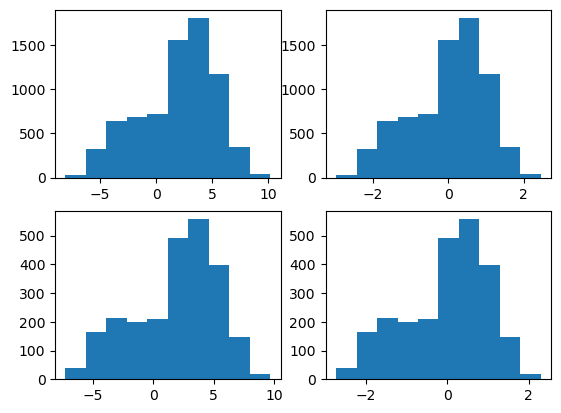

In [29]:
# visualizing the normaliation

fig, axes = plt.subplots(2,2)

axes[0,0].hist(y_train_raw.flatten())
axes[0,1].hist(y_train_scaled.flatten()) # rescaled to (-2,2)
axes[1,0].hist(y_test_raw.flatten())
axes[1,1].hist(y_test_scaled.flatten()) # rescaled to (-2,2)

In [30]:
# SAVE gdsc_Splited
with open("../data_temp/gdsc_Splited.dict", "wb") as f:
    pickle.dump(gdsc_Splited, f)

# create content-based filtering Neural Network (MLP)

## data and model functions

In [31]:
# view data
print(gdsc_Splited.keys())
for k in gdsc_Splited.keys():
    print(k)
    x = gdsc_Splited[k]["train"].shape
    print(x)

dict_keys(['y_gdsc', 'x_pheno', 'x_snv', 'x_gep', 'x_drug'])
y_gdsc
(7317,)
x_pheno
(7317, 15)
x_snv
(7317, 776)
x_gep
(7317, 776)
x_drug
(7317, 512)


In [32]:
# DIMENSION features: PHENO 15, SNV 776, GEP 776, DRUG 512
NDIM_PHENO = gdsc_Splited["x_pheno"]["train"].shape[1]
NDIM_SNV = gdsc_Splited["x_snv"]["train"].shape[1]
NDIM_GEP = gdsc_Splited["x_gep"]["train"].shape[1]
NDIM_DRUG = gdsc_Splited["x_drug"]["train"].shape[1]

Ndims = [NDIM_PHENO, NDIM_SNV, NDIM_GEP, NDIM_DRUG]
# double check
for v in Ndims:
    print(v)

15
776
776
512


In [33]:
class mlp_model:
    """create MLP model to predict drug response"""

    ### class attribute

    ### class method

    def __init__(self, NDIM_PHENO, NDIM_SNV, NDIM_GEP, NDIM_DRUG):

        # INPUT: 
        self.input_pheno = layers.Input(shape=(NDIM_PHENO), name="phenotype")
        self.input_snv = layers.Input(shape=(NDIM_SNV), name="SNV")
        self.input_gep = layers.Input(shape=(NDIM_GEP), name="GEP")
        self.input_drug = layers.Input(shape=(NDIM_DRUG), name="Drug_Smile")
        #
        self.input_sample = layers.concatenate(
            [self.input_pheno, self.input_snv, self.input_gep])
        self.input_binary = layers.concatenate(
            [self.input_pheno, self.input_snv, self.input_drug])
        

    def __str__(self):
        return '%s; %s' % (self.input_sample, self.input_drug)

    def create_sample_model(self, alpha, modelName="sample"):
        model_sample = Sequential(
            name = modelName,
            layers=[
#                 layers.Dense(units=256,
#                              activation="relu",
#                              kernel_regularizer=regularizers.L2(alpha),
#                              name= modelName + "_layer1"),
                layers.Dense(units=128,
                             activation="relu",
                             kernel_regularizer=regularizers.L2(alpha),
                             name= modelName + "_layer2"),
                layers.Dense(units=32,
                             activation="relu",
                             kernel_regularizer=regularizers.L2(alpha),
                             name= modelName + "_layer3"),
                layers.Dense(units=8,
                             activation="linear",
                             kernel_regularizer=regularizers.L2(alpha),
                             name= modelName + "_layer4")
            ])
        return model_sample

    def create_drug_model(self, alpha, modelName="drug_features"):
        model_drug = Sequential(
            name=modelName,
            layers=[
#                 layers.Dense(units=128,
#                              activation="relu",
#                              kernel_regularizer=regularizers.L2(alpha),
#                              name = modelName + "_layer1"),
                layers.Dense(units=32,
                             activation="relu",
                             kernel_regularizer=regularizers.L2(alpha),
                             name=modelName + "_layer2"),
                layers.Dense(units=8,
                             activation="linear",
                             kernel_regularizer=regularizers.L2(alpha),
                             name=modelName + "_layer3")
            ])
        return model_drug

    def create_dot_model(self, alpha):
        
        # create two part
        p1 = self.create_sample_model(alpha)
        p2 = self.create_drug_model(alpha)
        
        # normalize the vector to length 1
        norm_partA = linalg.l2_normalize(p1(self.input_sample), axis=1)
        norm_partB = linalg.l2_normalize(p2(self.input_drug), axis=1)

        # compute the dot product of the two vectors
        output = layers.Dot(axes=1,
                            name="Drug_sensitivity")([norm_partA, norm_partB])

        # specify the inputs and output of the model
        mod1 = Model([self.input_pheno, self.input_snv, self.input_gep, self.input_drug],
            output,
            name="Dot_model")
        return mod1

    def create_concat_model_sampleANDdrug(self, alpha):
        
        # create two part
        p1 = self.create_sample_model(alpha)
        p2 = self.create_drug_model(alpha)
        
        ### concat the output of the two parts
        x = layers.concatenate([p1(self.input_sample), p2(self.input_drug)], name="Concat_Layer")
        x = layers.Dense(6, activation="relu", name="combined_dense")(x)
        output = layers.Dense(1, name="drug_sensitivity")(x)

        # specify the inputs and output of the model
        mod1 = Model([
            self.input_pheno, self.input_snv, self.input_gep, self.input_drug],
                      output,
                      name="Concatenate_model")
        return mod1
    
    def create_concat_model_gep(self, alpha):
        
        # create two part
        p1 = self.create_sample_model(alpha, modelName="GEP_feature")
        p2 = self.create_drug_model(alpha, modelName="Binary_features")
        
        ### concat the output of the two parts
#         p2 = p2(self.input_binary)
#         p2 = layers.Dense(6, activation="relu", name="Binary_features_layer4")(p2)
        
        x = layers.concatenate([p1(self.input_gep), p2(self.input_binary)], name="Concat_Layer")
        x = layers.Dense(6, activation="relu", name="combined_dense")(x)
        output = layers.Dense(1, name="drug_sensitivity")(x)

        # specify the inputs and output of the model
        mod1 = Model([
            self.input_pheno, self.input_snv, self.input_gep, self.input_drug],
                      output,
                      name="Concatenate_model")
        return mod1

In [34]:
# test
m = mlp_model(15, 776, 776, 512)
md = m.create_dot_model(0.1)
mc1 = m.create_concat_model_sampleANDdrug(0.1)
mc2 = m.create_concat_model_gep(0.1)

2024-10-09 12:02:27.887990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
mc2.summary()

Model: "Concatenate_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phenotype (InputLayer)         [(None, 15)]         0           []                               
                                                                                                  
 SNV (InputLayer)               [(None, 776)]        0           []                               
                                                                                                  
 Drug_Smile (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 GEP (InputLayer)               [(None, 776)]        0           []                               
                                                                                  

In [36]:
utils.plot_model(md, "../data_temp/md.pdf", show_shapes = True)
utils.plot_model(mc1, "../data_temp/mc1.pdf", show_shapes = True)
utils.plot_model(mc2, "../data_temp/mc2.pdf", show_shapes = True)

# train hyper-parameter

In [37]:
#set early stopping criteria
pat = 10  #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='loss', patience=pat, verbose=1)

BATCH_SIZE = 64

#define a function to fit the model
def fit_and_evaluate(model_type, t_x, t_y, val_x, val_y, alpha=1e-3, epochs=2, batch_size=BATCH_SIZE):
    
    mod_basic = None # Initialize mode, IMPORTANT
    mod_basic = mlp_model(15, 776, 776, 512)
    
    if model_type == "dot":
        model = mod_basic.create_dot_model(alpha)
    if model_type == "concat_sample":
        model = mod_basic.create_concat_model_sampleANDdrug(alpha)
    if model_type == "concat_gep":
        model = mod_basic.create_concat_model_gep(alpha)
    
    cost_fn = losses.MeanSquaredError()
    opt = optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss=cost_fn, metrics = "mse")
    
    history = model.fit(t_x,
                        t_y,
                        epochs = epochs,
                        batch_size = batch_size,
                        callbacks=early_stopping,
                        # callbacks=[early_stopping, model_checkpoint],
                        verbose=1)
    score_val = model.evaluate(val_x, val_y)
    return [history.history, score_val]

In [38]:
# insert: Learn StratifiedKFold

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([11, 22, 11, 22])
skf = StratifiedKFold(n_splits=2, shuffle = False)
print(skf.get_n_splits(X, y))

print(skf)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    
# Why the index of train and test are different?
# Of course, they should be different!! they are X_train and X_test index
# they are not index of X and y, you are mislead by the skf.split(X,y)
# you mistakely think the index are for X and y

2
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
Fold 0:
  Train: index=[2 3]
  Test:  index=[0 1]
Fold 1:
  Train: index=[0 1]
  Test:  index=[2 3]


In [39]:
# set kfold first
# QUESTION: StratifiedKFold vs. GroupKFold, which one should I use?
# ANSWER: StratifiedKFold, and stratify by drugs.
# why no GroupKFold, this split data by goup id, i.e., 
# a,b,c groups for train, and d group for test

y_t = gdsc_Splited['y_gdsc']['train_norm']
drug_full = gdsc_Splited['y_gdsc']['train'].index.get_level_values(1)
# print(f"drug_full: \n{pd.Series(drug_full).value_counts()}\n")

skf = StratifiedKFold(n_splits=2, shuffle = False)
index_skf = enumerate(skf.split(drug_full, drug_full))

for i, (train_index, test_index) in index_skf:
    if i == 0:
        print(f"Fold {i}:")
#         print(f"Train value counts:\n{pd.Series(drug_full[train_index]).value_counts()}")
#         print(f"Test value_counts:\n{pd.Series(drug_full[test_index]).value_counts()}")

# CORRECT

Fold 0:


In [19]:
# test model

y_t = gdsc_Splited['y_gdsc']['train_norm']
xs = ['x_pheno', 'x_snv', 'x_gep', 'x_drug']
x_t = [gdsc_Splited[e]['train'].astype("float64").to_numpy() for e in xs]

# test model
res = fit_and_evaluate("concat_gep", x_t, y_t, x_t, y_t, epochs=10, batch_size=64)

Epoch 1/10
115/115 [==============================] - 1s 3ms/step - loss: 1.4722 - mse: 1.1867
Epoch 2/10
115/115 [==============================] - 0s 3ms/step - loss: 1.2463 - mse: 1.0000
Epoch 3/10
115/115 [==============================] - 0s 3ms/step - loss: 1.2293 - mse: 1.0001
Epoch 4/10
115/115 [==============================] - 0s 3ms/step - loss: 1.2157 - mse: 1.0001
Epoch 5/10
115/115 [==============================] - 0s 3ms/step - loss: 1.2040 - mse: 1.0001
Epoch 6/10
115/115 [==============================] - 0s 3ms/step - loss: 1.1936 - mse: 1.0001
Epoch 7/10
115/115 [==============================] - 0s 3ms/step - loss: 1.1842 - mse: 1.0001
Epoch 8/10
115/115 [==============================] - 0s 3ms/step - loss: 1.1757 - mse: 1.0001
Epoch 9/10
115/115 [==============================] - 0s 3ms/step - loss: 1.1679 - mse: 1.0001
Epoch 10/10
229/229 [==============================] - 0s 1ms/step - loss: 1.1618 - mse: 1.0000


In [20]:
# HYPERPARAMETER: ALPHA, MODEL

# https://github.com/keras-team/keras/issues/1711
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md

SEED = 0
random.set_seed(SEED)

# for test only
# N_FOLD = 2
# N_EPOCHES = 2
# BATCH_SIZE = 128
# ALPHA_list = [1, 0.1]

# actually run
N_FOLD = 10
N_EPOCHES = 200
BATCH_SIZE = 64
# HYPERPARAMETER
ALPHA_list = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]


#
y_t = gdsc_Splited['y_gdsc']['train_norm']
xs = ['x_pheno', 'x_snv', 'x_gep', 'x_drug']
x_t = [gdsc_Splited[e]['train'].astype("float64").to_numpy() for e in xs]
drug_full = gdsc_Splited['y_gdsc']['train'].index.get_level_values(1)
#
skf = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
index_skf = list(skf.split(X=y_t, y=drug_full))

dict_train_perAlpha = {'dot':pd.DataFrame(), "concat_sample":pd.DataFrame(), "concat_gep":pd.DataFrame()}
dict_test_perAlpha = {'dot':pd.DataFrame(), "concat_sample":pd.DataFrame(), "concat_gep":pd.DataFrame()}

def extract_info_from_res(res):
    score_train = pd.DataFrame.from_dict(res[0])
    score_train.index = [
        "Epoch" + str(e) for e in range(1, len(res[0]['loss']) + 1)
    ]
    score_train["Fold"] = i + 1

    score_test = pd.DataFrame(res[1],
                              index=["loss", "mse"],
                              columns=["Fold_" + str(i + 1)])
    
    x = {'train':score_train, 'test':score_test}
    return x   

for alpha in ALPHA_list:

    dict_train_perFold = {'dot':pd.DataFrame(), "concat_sample":pd.DataFrame(), "concat_gep":pd.DataFrame()}
    dict_test_perFold = {'dot':pd.DataFrame(), "concat_sample":pd.DataFrame(), "concat_gep":pd.DataFrame()}

    for i, (i_t, i_val) in enumerate(index_skf):
        print(f"Runing with alpha: {alpha}")
        print("    Running Fold", i + 1, "/", N_FOLD)
        #
        x_tt = [e[i_t] for e in x_t]
        x_tv = [e[i_val] for e in x_t]
        #
        for m in ["dot", "concat_sample", "concat_gep"]:
            res = fit_and_evaluate(m,
                                   x_tt,
                                   y_t[i_t],
                                   x_tv,
                                   y_t[i_val],
                                   alpha=alpha,
                                   epochs=N_EPOCHES)
            res = extract_info_from_res(res)
            dict_train_perFold[m] = pd.concat([dict_train_perFold[m], res['train']], axis=0)
            dict_test_perFold[m] = pd.concat([dict_test_perFold[m], res['test']], axis=1)
        
    for m in ["dot", "concat_sample", "concat_gep"]: 
        dict_train_perFold[m]["alpha"] = alpha
        dict_test_perFold[m]["alpha"] = alpha
        #
        dict_train_perAlpha[m] = pd.concat([dict_train_perAlpha[m], dict_train_perFold[m]], axis=0)
        dict_test_perAlpha[m] = pd.concat([dict_test_perAlpha[m], dict_test_perFold[m]], axis=0)

Runing with alpha: 1
    Running Fold 1 / 10
Epoch 1/200
103/103 [==============================] - 1s 4ms/step - loss: 99.7814 - mse: 0.3829
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 11.9751 - mse: 0.3139
Epoch 3/200
103/103 [==============================] - 0s 3ms/step - loss: 3.6946 - mse: 0.3108
Epoch 4/200
103/103 [==============================] - 0s 3ms/step - loss: 1.4146 - mse: 0.3120
Epoch 5/200
103/103 [==============================] - 0s 3ms/step - loss: 0.6757 - mse: 0.3126
Epoch 6/200
103/103 [==============================] - 0s 3ms/step - loss: 0.4355 - mse: 0.3137
Epoch 7/200
103/103 [==============================] - 0s 3ms/step - loss: 0.3579 - mse: 0.3111
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3400 - mse: 0.3114
Epoch 9/200
103/103 [==============================] - 0s 3ms/step - loss: 0.3404 - mse: 0.3135
Epoch 10/200
103/103 [==============================] - 0s 3ms/step - loss: 0.3305 - mse:

103/103 [==============================] - 0s 3ms/step - loss: 0.3522 - mse: 0.2664
Epoch 40/200
103/103 [==============================] - 0s 3ms/step - loss: 0.3436 - mse: 0.2605
Epoch 41/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3449 - mse: 0.2634
Epoch 42/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3399 - mse: 0.2608
Epoch 43/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3397 - mse: 0.2625
Epoch 44/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3353 - mse: 0.2591
Epoch 45/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3339 - mse: 0.2605
Epoch 46/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3336 - mse: 0.2605
Epoch 47/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3313 - mse: 0.2611
Epoch 48/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3321 - mse: 0.2625
Epoch 49/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.3029 - mse: 0.2395
Epoch 86/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3024 - mse: 0.2388
Epoch 87/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3007 - mse: 0.2390
Epoch 88/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3019 - mse: 0.2414
Epoch 89/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2970 - mse: 0.2361
Epoch 90/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2934 - mse: 0.2345
Epoch 91/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2935 - mse: 0.2341
Epoch 92/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2954 - mse: 0.2362
Epoch 93/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2961 - mse: 0.2355
Epoch 94/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2992 - mse: 0.2392
Epoch 95/200
103/103 [=====================

103/103 [==============================] - 0s 3ms/step - loss: 0.3690 - mse: 0.2732
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3625 - mse: 0.2703
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3567 - mse: 0.2673
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3562 - mse: 0.2687
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3551 - mse: 0.2709
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3478 - mse: 0.2661
Epoch 32/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3479 - mse: 0.2679
Epoch 33/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3479 - mse: 0.2697
Epoch 34/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3475 - mse: 0.2706
Epoch 35/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3383 - mse: 0.2643
Epoch 36/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.3295 - mse: 0.2491
Epoch 81/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3223 - mse: 0.2434
Epoch 82/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3248 - mse: 0.2465
Epoch 83/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3329 - mse: 0.2525
Epoch 84/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3253 - mse: 0.2490
Epoch 85/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3205 - mse: 0.2440
Epoch 86/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3239 - mse: 0.2476
Epoch 87/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3203 - mse: 0.2445
Epoch 88/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3134 - mse: 0.2373
Epoch 89/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3220 - mse: 0.2470
Epoch 90/200
103/103 [=====================

103/103 [==============================] - 0s 3ms/step - loss: 0.4011 - mse: 0.2775
Epoch 28/200
103/103 [==============================] - 0s 3ms/step - loss: 0.3946 - mse: 0.2746
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3909 - mse: 0.2757
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3827 - mse: 0.2708
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3762 - mse: 0.2682
Epoch 32/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3723 - mse: 0.2682
Epoch 33/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3689 - mse: 0.2666
Epoch 34/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3657 - mse: 0.2664
Epoch 35/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3649 - mse: 0.2686
Epoch 36/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3607 - mse: 0.2677
Epoch 37/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.3026 - mse: 0.2434
Epoch 74/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3021 - mse: 0.2412
Epoch 75/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2975 - mse: 0.2397
Epoch 76/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3016 - mse: 0.2432
Epoch 77/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2963 - mse: 0.2398
Epoch 78/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3033 - mse: 0.2458
Epoch 79/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3106 - mse: 0.2531
Epoch 80/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2958 - mse: 0.2393
Epoch 81/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2980 - mse: 0.2422
Epoch 82/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2930 - mse: 0.2374
Epoch 83/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2945 - mse: 0.2594
Epoch 89/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2975 - mse: 0.2623
Epoch 90/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2953 - mse: 0.2607
Epoch 91/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2939 - mse: 0.2598
Epoch 92/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2922 - mse: 0.2566
Epoch 93/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2992 - mse: 0.2626
Epoch 94/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2964 - mse: 0.2632
Epoch 95/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2962 - mse: 0.2621
Epoch 96/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2984 - mse: 0.2646
Epoch 97/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2959 - mse: 0.2628
Epoch 98/200
103/103 [=====================

Epoch 4/200
103/103 [==============================] - 0s 3ms/step - loss: 7.5733 - mse: 0.3313
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 4.1756 - mse: 0.3299
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 2.5492 - mse: 0.3203
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 1.6933 - mse: 0.3066
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 1.2098 - mse: 0.2974
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9245 - mse: 0.2920
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 0.7441 - mse: 0.2859
Epoch 11/200
103/103 [==============================] - 0s 4ms/step - loss: 0.6303 - mse: 0.2848
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 0.5524 - mse: 0.2827
Epoch 13/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4986 - mse: 0.2789
Epoch 14/200
103/103 [==============

103/103 [==============================] - 0s 3ms/step - loss: 0.3263 - mse: 0.2463
Epoch 40/200
103/103 [==============================] - 0s 3ms/step - loss: 0.3221 - mse: 0.2427
Epoch 41/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3265 - mse: 0.2470
Epoch 42/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3249 - mse: 0.2469
Epoch 43/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3222 - mse: 0.2461
Epoch 44/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3141 - mse: 0.2375
Epoch 45/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3172 - mse: 0.2429
Epoch 46/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3227 - mse: 0.2463
Epoch 47/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3178 - mse: 0.2441
Epoch 48/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3154 - mse: 0.2423
Epoch 49/200
103/103 [=====================

103/103 [==============================] - 0s 5ms/step - loss: 0.3279 - mse: 0.3107
Epoch 25/200
103/103 [==============================] - 0s 5ms/step - loss: 0.3337 - mse: 0.3138
Epoch 26/200
103/103 [==============================] - 0s 5ms/step - loss: 0.3275 - mse: 0.3105
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3361 - mse: 0.3135
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3294 - mse: 0.3118
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3240 - mse: 0.3088
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3283 - mse: 0.3098
Epoch 31/200
103/103 [==============================] - 0s 5ms/step - loss: 0.3283 - mse: 0.3106
Epoch 32/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3292 - mse: 0.3107
Epoch 33/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3478 - mse: 0.3162
Epoch 34/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.6244 - mse: 0.2919
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 0.5590 - mse: 0.2936
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 0.5062 - mse: 0.2812
Epoch 11/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4729 - mse: 0.2756
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4508 - mse: 0.2718
Epoch 13/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4357 - mse: 0.2705
Epoch 14/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4234 - mse: 0.2675
Epoch 15/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4180 - mse: 0.2709
Epoch 16/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4039 - mse: 0.2635
Epoch 17/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3960 - mse: 0.2624
Epoch 18/200
103/103 [======================

103/103 [==============================] - 0s 3ms/step - loss: 0.3201 - mse: 0.2606
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3229 - mse: 0.2652
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3211 - mse: 0.2643
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3164 - mse: 0.2612
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3180 - mse: 0.2634
Epoch 32/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3172 - mse: 0.2639
Epoch 33/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3128 - mse: 0.2610
Epoch 34/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3142 - mse: 0.2622
Epoch 35/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3109 - mse: 0.2607
Epoch 36/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3075 - mse: 0.2584
Epoch 37/200
103/103 [=====================

103/103 [==============================] - 0s 5ms/step - loss: 3.3228 - mse: 0.3132
Epoch 4/200
103/103 [==============================] - 0s 5ms/step - loss: 1.2755 - mse: 0.3121
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 0.6326 - mse: 0.3135
Epoch 6/200
103/103 [==============================] - 0s 5ms/step - loss: 0.4262 - mse: 0.3146
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3632 - mse: 0.3127
Epoch 8/200
103/103 [==============================] - 0s 5ms/step - loss: 0.3428 - mse: 0.3123
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3424 - mse: 0.3134
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3417 - mse: 0.3108
Epoch 11/200
103/103 [==============================] - 0s 5ms/step - loss: 0.3393 - mse: 0.3132
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3378 - mse: 0.3121
Epoch 13/200
103/103 [===========================

103/103 [==============================] - 0s 4ms/step - loss: 0.2923 - mse: 0.2649
Epoch 137/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2868 - mse: 0.2593
Epoch 138/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2895 - mse: 0.2624
Epoch 139/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2936 - mse: 0.2658
Epoch 140/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2886 - mse: 0.2611
Epoch 140: early stopping
23/23 [==============================] - 0s 1ms/step - loss: 0.2955 - mse: 0.2678
Epoch 1/200
103/103 [==============================] - 1s 3ms/step - loss: 163.0555 - mse: 1.2640
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 37.6586 - mse: 0.9999
Epoch 3/200
103/103 [==============================] - 0s 4ms/step - loss: 13.8334 - mse: 0.9998
Epoch 4/200
103/103 [==============================] - 0s 4ms/step - loss: 6.1534 - mse: 0.9998
Epoch 5/200
103/103 [=======

103/103 [==============================] - 0s 4ms/step - loss: 0.3172 - mse: 0.2657
Epoch 43/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3156 - mse: 0.2648
Epoch 44/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3169 - mse: 0.2667
Epoch 45/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3159 - mse: 0.2663
Epoch 46/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3148 - mse: 0.2659
Epoch 47/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3113 - mse: 0.2629
Epoch 48/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3103 - mse: 0.2627
Epoch 49/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3102 - mse: 0.2634
Epoch 50/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3124 - mse: 0.2658
Epoch 51/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3106 - mse: 0.2646
Epoch 52/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.3064 - mse: 0.2447
Epoch 96/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3044 - mse: 0.2427
Epoch 97/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2982 - mse: 0.2385
Epoch 98/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3038 - mse: 0.2432
Epoch 99/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2979 - mse: 0.2387
Epoch 100/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2983 - mse: 0.2378
Epoch 101/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2997 - mse: 0.2410
Epoch 102/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3019 - mse: 0.2437
Epoch 103/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2985 - mse: 0.2417
Epoch 104/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2945 - mse: 0.2369
Epoch 105/200
103/103 [===============

103/103 [==============================] - 0s 4ms/step - loss: 0.2952 - mse: 0.2612
Epoch 79/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2975 - mse: 0.2629
Epoch 80/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2958 - mse: 0.2626
Epoch 81/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2911 - mse: 0.2582
Epoch 82/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2942 - mse: 0.2610
Epoch 83/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2902 - mse: 0.2577
Epoch 84/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2924 - mse: 0.2600
Epoch 85/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2959 - mse: 0.2637
Epoch 86/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2919 - mse: 0.2603
Epoch 87/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2909 - mse: 0.2585
Epoch 88/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.3751 - mse: 0.2313
Epoch 20/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3601 - mse: 0.2305
Epoch 21/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3569 - mse: 0.2388
Epoch 22/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3439 - mse: 0.2375
Epoch 23/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3322 - mse: 0.2343
Epoch 24/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3208 - mse: 0.2304
Epoch 25/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3203 - mse: 0.2366
Epoch 26/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3219 - mse: 0.2447
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3067 - mse: 0.2358
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3065 - mse: 0.2392
Epoch 29/200
103/103 [=====================

103/103 [==============================] - 0s 5ms/step - loss: 0.3393 - mse: 0.3075
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3282 - mse: 0.3078
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3210 - mse: 0.3068
Epoch 9/200
103/103 [==============================] - 0s 5ms/step - loss: 0.3194 - mse: 0.3069
Epoch 10/200
103/103 [==============================] - 0s 5ms/step - loss: 0.3185 - mse: 0.3073
Epoch 11/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3178 - mse: 0.3065
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3154 - mse: 0.3054
Epoch 13/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3151 - mse: 0.3060
Epoch 14/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3157 - mse: 0.3061
Epoch 15/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3156 - mse: 0.3065
Epoch 16/200
103/103 [========================

103/103 [==============================] - 0s 4ms/step - loss: 0.2566 - mse: 0.2163
Epoch 62/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2563 - mse: 0.2157
Epoch 63/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2655 - mse: 0.2254
Epoch 64/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2607 - mse: 0.2219
Epoch 65/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2540 - mse: 0.2152
Epoch 66/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2629 - mse: 0.2250
Epoch 67/200
103/103 [==============================] - 0s 3ms/step - loss: 0.2542 - mse: 0.2164
Epoch 68/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2535 - mse: 0.2157
Epoch 69/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2548 - mse: 0.2173
Epoch 70/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2516 - mse: 0.2155
Epoch 71/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2686 - mse: 0.2340
Epoch 59/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2674 - mse: 0.2331
Epoch 60/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2672 - mse: 0.2339
Epoch 61/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2640 - mse: 0.2297
Epoch 62/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2645 - mse: 0.2306
Epoch 63/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2658 - mse: 0.2327
Epoch 64/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2635 - mse: 0.2306
Epoch 65/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2608 - mse: 0.2277
Epoch 66/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2653 - mse: 0.2323
Epoch 67/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2623 - mse: 0.2303
Epoch 68/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.3593 - mse: 0.3036
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3310 - mse: 0.3036
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3246 - mse: 0.3061
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3214 - mse: 0.3064
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3160 - mse: 0.3030
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3132 - mse: 0.3017
Epoch 11/200
103/103 [==============================] - 0s 5ms/step - loss: 0.3164 - mse: 0.3045
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3149 - mse: 0.3028
Epoch 13/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3122 - mse: 0.3012
Epoch 14/200
103/103 [==============================] - 0s 5ms/step - loss: 0.3113 - mse: 0.3016
Epoch 15/200
103/103 [=========================

103/103 [==============================] - 0s 4ms/step - loss: 0.5433 - mse: 0.2987
Epoch 18/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4985 - mse: 0.2829
Epoch 19/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4670 - mse: 0.2762
Epoch 20/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4392 - mse: 0.2682
Epoch 21/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4235 - mse: 0.2685
Epoch 22/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4068 - mse: 0.2656
Epoch 23/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3867 - mse: 0.2581
Epoch 24/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3761 - mse: 0.2580
Epoch 25/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3562 - mse: 0.2476
Epoch 26/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3481 - mse: 0.2473
Epoch 27/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2923 - mse: 0.2556
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2868 - mse: 0.2524
Epoch 32/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2960 - mse: 0.2622
Epoch 33/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2872 - mse: 0.2565
Epoch 34/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2834 - mse: 0.2541
Epoch 35/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2828 - mse: 0.2542
Epoch 36/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2852 - mse: 0.2569
Epoch 37/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2830 - mse: 0.2557
Epoch 38/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2809 - mse: 0.2538
Epoch 39/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2830 - mse: 0.2570
Epoch 40/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2521 - mse: 0.2134
Epoch 89/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2577 - mse: 0.2184
Epoch 90/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2574 - mse: 0.2188
Epoch 91/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2540 - mse: 0.2159
Epoch 92/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2537 - mse: 0.2157
Epoch 93/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2543 - mse: 0.2168
Epoch 94/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2492 - mse: 0.2115
Epoch 95/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2568 - mse: 0.2186
Epoch 96/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2551 - mse: 0.2175
Epoch 97/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2492 - mse: 0.2127
Epoch 98/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2490 - mse: 0.2217
Epoch 89/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2469 - mse: 0.2188
Epoch 90/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2477 - mse: 0.2205
Epoch 91/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2514 - mse: 0.2243
Epoch 92/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2485 - mse: 0.2218
Epoch 93/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2507 - mse: 0.2239
Epoch 94/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2449 - mse: 0.2185
Epoch 95/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2442 - mse: 0.2174
Epoch 96/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2453 - mse: 0.2187
Epoch 97/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2507 - mse: 0.2243
Epoch 98/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.3169 - mse: 0.2439
Epoch 23/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3113 - mse: 0.2422
Epoch 24/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3088 - mse: 0.2420
Epoch 25/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3083 - mse: 0.2444
Epoch 26/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3047 - mse: 0.2429
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3022 - mse: 0.2435
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3001 - mse: 0.2433
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3020 - mse: 0.2469
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2989 - mse: 0.2456
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2964 - mse: 0.2451
Epoch 32/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2385 - mse: 0.2111
Epoch 102/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2353 - mse: 0.2081
Epoch 103/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2354 - mse: 0.2080
Epoch 104/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2361 - mse: 0.2093
Epoch 105/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2360 - mse: 0.2092
Epoch 106/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2374 - mse: 0.2102
Epoch 107/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2398 - mse: 0.2131
Epoch 108/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2399 - mse: 0.2132
Epoch 108: early stopping
23/23 [==============================] - 0s 1ms/step - loss: 0.2458 - mse: 0.2188
Runing with alpha: 0.1
    Running Fold 8 / 10
Epoch 1/200
103/103 [==============================] - 1s 3ms/step - loss: 

Epoch 42/200
103/103 [==============================] - 0s 3ms/step - loss: 0.2693 - mse: 0.2370
Epoch 43/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2682 - mse: 0.2372
Epoch 44/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2676 - mse: 0.2359
Epoch 45/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2624 - mse: 0.2323
Epoch 46/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2637 - mse: 0.2316
Epoch 47/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2614 - mse: 0.2304
Epoch 48/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2613 - mse: 0.2307
Epoch 49/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2629 - mse: 0.2322
Epoch 50/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2613 - mse: 0.2310
Epoch 51/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2638 - mse: 0.2332
Epoch 52/200
103/103 [========

103/103 [==============================] - 0s 4ms/step - loss: 0.3586 - mse: 0.2483
Epoch 15/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3444 - mse: 0.2441
Epoch 16/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3349 - mse: 0.2433
Epoch 17/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3291 - mse: 0.2437
Epoch 18/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3233 - mse: 0.2441
Epoch 19/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3137 - mse: 0.2394
Epoch 20/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3140 - mse: 0.2450
Epoch 21/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3025 - mse: 0.2362
Epoch 22/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3041 - mse: 0.2403
Epoch 23/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3028 - mse: 0.2428
Epoch 24/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2433 - mse: 0.2147
Epoch 123/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2437 - mse: 0.2147
Epoch 124/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2440 - mse: 0.2154
Epoch 125/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2444 - mse: 0.2157
Epoch 126/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2468 - mse: 0.2176
Epoch 127/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2426 - mse: 0.2142
Epoch 128/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2398 - mse: 0.2116
Epoch 129/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2505 - mse: 0.2223
Epoch 130/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2427 - mse: 0.2141
Epoch 131/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2422 - mse: 0.2140
Epoch 132/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.2545 - mse: 0.2270
Epoch 109/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2486 - mse: 0.2217
Epoch 110/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2483 - mse: 0.2209
Epoch 110: early stopping
23/23 [==============================] - 0s 1ms/step - loss: 0.2744 - mse: 0.2473
Epoch 1/200
103/103 [==============================] - 1s 2ms/step - loss: 23.9351 - mse: 1.2719
Epoch 2/200
103/103 [==============================] - 0s 3ms/step - loss: 12.7682 - mse: 1.0038
Epoch 3/200
103/103 [==============================] - 0s 4ms/step - loss: 8.3035 - mse: 1.0038
Epoch 4/200
103/103 [==============================] - 0s 4ms/step - loss: 5.7381 - mse: 1.0038
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 4.1626 - mse: 1.0038
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 2.9921 - mse: 0.7439
Epoch 7/200
103/103 [=============

Epoch 13/200
103/103 [==============================] - 0s 4ms/step - loss: 0.5605 - mse: 0.2149
Epoch 14/200
103/103 [==============================] - 0s 4ms/step - loss: 0.5239 - mse: 0.2120
Epoch 15/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4999 - mse: 0.2174
Epoch 16/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4662 - mse: 0.2097
Epoch 17/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4476 - mse: 0.2145
Epoch 18/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4308 - mse: 0.2184
Epoch 19/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4044 - mse: 0.2106
Epoch 20/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3866 - mse: 0.2095
Epoch 21/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3807 - mse: 0.2179
Epoch 22/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3646 - mse: 0.2152
Epoch 23/200
103/103 [========

103/103 [==============================] - 0s 4ms/step - loss: 0.2032 - mse: 0.1667
Epoch 80/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1995 - mse: 0.1626
Epoch 81/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1959 - mse: 0.1601
Epoch 82/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1959 - mse: 0.1598
Epoch 83/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1980 - mse: 0.1620
Epoch 84/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2018 - mse: 0.1666
Epoch 85/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1994 - mse: 0.1637
Epoch 86/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1981 - mse: 0.1623
Epoch 87/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1976 - mse: 0.1624
Epoch 88/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1940 - mse: 0.1590
Epoch 89/200
103/103 [=====================

103/103 [==============================] - 0s 3ms/step - loss: 0.2270 - mse: 0.1933
Epoch 62/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2364 - mse: 0.2026
Epoch 63/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2409 - mse: 0.2072
Epoch 64/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2333 - mse: 0.2000
Epoch 65/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2232 - mse: 0.1904
Epoch 66/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2284 - mse: 0.1963
Epoch 67/200
103/103 [==============================] - 0s 3ms/step - loss: 0.2303 - mse: 0.1983
Epoch 68/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2271 - mse: 0.1951
Epoch 69/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2235 - mse: 0.1916
Epoch 70/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2220 - mse: 0.1905
Epoch 71/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1780 - mse: 0.1466
Epoch 148/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1772 - mse: 0.1461
Epoch 149/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1801 - mse: 0.1493
Epoch 150/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1808 - mse: 0.1501
Epoch 151/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1848 - mse: 0.1541
Epoch 152/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1827 - mse: 0.1517
Epoch 153/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1775 - mse: 0.1464
Epoch 154/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1819 - mse: 0.1510
Epoch 155/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1844 - mse: 0.1535
Epoch 156/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1791 - mse: 0.1481
Epoch 157/200
103/103 [===========

103/103 [==============================] - 0s 3ms/step - loss: 0.2178 - mse: 0.1933
Epoch 80/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2093 - mse: 0.1853
Epoch 81/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2161 - mse: 0.1919
Epoch 82/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2064 - mse: 0.1820
Epoch 83/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2105 - mse: 0.1857
Epoch 84/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2161 - mse: 0.1919
Epoch 85/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2232 - mse: 0.2003
Epoch 86/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2156 - mse: 0.1936
Epoch 87/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2189 - mse: 0.1971
Epoch 88/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2178 - mse: 0.1961
Epoch 89/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1774 - mse: 0.1471
Epoch 155/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1794 - mse: 0.1493
Epoch 156/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1800 - mse: 0.1500
Epoch 157/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1793 - mse: 0.1493
Epoch 158/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1775 - mse: 0.1481
Epoch 159/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1786 - mse: 0.1489
Epoch 160/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1759 - mse: 0.1463
Epoch 161/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1822 - mse: 0.1525
Epoch 162/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1812 - mse: 0.1512
Epoch 163/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1812 - mse: 0.1504
Epoch 164/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.2129 - mse: 0.1923
Epoch 82/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2163 - mse: 0.1960
Epoch 83/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2190 - mse: 0.1987
Epoch 84/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2180 - mse: 0.1981
Epoch 85/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2120 - mse: 0.1918
Epoch 86/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2105 - mse: 0.1905
Epoch 87/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2136 - mse: 0.1934
Epoch 88/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2162 - mse: 0.1963
Epoch 89/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2142 - mse: 0.1943
Epoch 90/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2122 - mse: 0.1924
Epoch 91/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2838 - mse: 0.2700
Epoch 35/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2859 - mse: 0.2721
Epoch 36/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2851 - mse: 0.2710
Epoch 37/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2842 - mse: 0.2710
Epoch 38/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2825 - mse: 0.2688
Epoch 39/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2829 - mse: 0.2693
Epoch 40/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2809 - mse: 0.2679
Epoch 41/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2810 - mse: 0.2677
Epoch 42/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2871 - mse: 0.2738
Epoch 43/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2840 - mse: 0.2710
Epoch 44/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2420 - mse: 0.1932
Epoch 22/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2387 - mse: 0.1912
Epoch 23/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2337 - mse: 0.1871
Epoch 24/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2349 - mse: 0.1896
Epoch 25/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2386 - mse: 0.1943
Epoch 26/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2321 - mse: 0.1888
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2311 - mse: 0.1887
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2267 - mse: 0.1855
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2306 - mse: 0.1899
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2320 - mse: 0.1920
Epoch 31/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.6926 - mse: 0.2053
Epoch 24/200
103/103 [==============================] - 0s 4ms/step - loss: 0.6700 - mse: 0.2080
Epoch 25/200
103/103 [==============================] - 0s 4ms/step - loss: 0.6442 - mse: 0.2061
Epoch 26/200
103/103 [==============================] - 0s 4ms/step - loss: 0.6219 - mse: 0.2068
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 0.6051 - mse: 0.2115
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 0.5808 - mse: 0.2073
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.5525 - mse: 0.1982
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.5373 - mse: 0.2016
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.5161 - mse: 0.1982
Epoch 32/200
103/103 [==============================] - 0s 4ms/step - loss: 0.5017 - mse: 0.2004
Epoch 33/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2283 - mse: 0.1782
Epoch 47/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2211 - mse: 0.1716
Epoch 48/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2303 - mse: 0.1812
Epoch 49/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2203 - mse: 0.1726
Epoch 50/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2193 - mse: 0.1723
Epoch 51/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2179 - mse: 0.1714
Epoch 52/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2244 - mse: 0.1788
Epoch 53/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2215 - mse: 0.1759
Epoch 54/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2169 - mse: 0.1719
Epoch 55/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2154 - mse: 0.1713
Epoch 56/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2858 - mse: 0.2739
Epoch 60/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2821 - mse: 0.2700
Epoch 60: early stopping
23/23 [==============================] - 0s 1ms/step - loss: 0.2884 - mse: 0.2766
Epoch 1/200
103/103 [==============================] - 1s 2ms/step - loss: 5.0226 - mse: 2.2532
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 3.0943 - mse: 0.9989
Epoch 3/200
103/103 [==============================] - 0s 4ms/step - loss: 2.7994 - mse: 0.9989
Epoch 4/200
103/103 [==============================] - 0s 4ms/step - loss: 2.5994 - mse: 0.9989
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 2.4512 - mse: 0.9989
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 2.3349 - mse: 0.9989
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 2.2398 - mse: 0.9989
Epoch 8/200
103/103 [===================

103/103 [==============================] - 0s 4ms/step - loss: 0.2672 - mse: 0.2187
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2691 - mse: 0.2228
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2624 - mse: 0.2173
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2628 - mse: 0.2188
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2632 - mse: 0.2201
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2532 - mse: 0.2110
Epoch 32/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2496 - mse: 0.2084
Epoch 33/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2469 - mse: 0.2069
Epoch 34/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2488 - mse: 0.2094
Epoch 35/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2411 - mse: 0.2029
Epoch 36/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.4162 - mse: 0.2968
Epoch 5/200
103/103 [==============================] - 0s 5ms/step - loss: 0.3775 - mse: 0.2956
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3496 - mse: 0.2913
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3358 - mse: 0.2895
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3254 - mse: 0.2872
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3152 - mse: 0.2832
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3116 - mse: 0.2829
Epoch 11/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3078 - mse: 0.2821
Epoch 12/200
103/103 [==============================] - 0s 5ms/step - loss: 0.3054 - mse: 0.2814
Epoch 13/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2988 - mse: 0.2764
Epoch 14/200
103/103 [==========================

103/103 [==============================] - 0s 4ms/step - loss: 2.0859 - mse: 0.9999
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 1.9758 - mse: 0.9999
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 1.8793 - mse: 0.9999
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 1.7939 - mse: 0.9999
Epoch 11/200
103/103 [==============================] - 0s 4ms/step - loss: 1.7179 - mse: 0.9999
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 1.6498 - mse: 0.9999
Epoch 13/200
103/103 [==============================] - 0s 4ms/step - loss: 1.5884 - mse: 0.9999
Epoch 14/200
103/103 [==============================] - 0s 4ms/step - loss: 1.5330 - mse: 0.9999
Epoch 15/200
103/103 [==============================] - 0s 4ms/step - loss: 1.4826 - mse: 0.9998
Epoch 16/200
103/103 [==============================] - 0s 4ms/step - loss: 1.4369 - mse: 0.9999
Epoch 17/200
103/103 [=======================

103/103 [==============================] - 0s 4ms/step - loss: 0.2955 - mse: 0.2792
Epoch 23/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2904 - mse: 0.2746
Epoch 24/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2902 - mse: 0.2745
Epoch 25/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2910 - mse: 0.2754
Epoch 26/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2905 - mse: 0.2752
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2913 - mse: 0.2761
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2865 - mse: 0.2718
Epoch 29/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2909 - mse: 0.2762
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2927 - mse: 0.2783
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2906 - mse: 0.2762
Epoch 32/200
103/103 [=====================

23/23 [==============================] - 0s 1ms/step - loss: 0.2059 - mse: 0.1835
Epoch 1/200
103/103 [==============================] - 1s 3ms/step - loss: 3.4724 - mse: 0.6148
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 2.4942 - mse: 0.2458
Epoch 3/200
103/103 [==============================] - 0s 4ms/step - loss: 2.1361 - mse: 0.2268
Epoch 4/200
103/103 [==============================] - 0s 4ms/step - loss: 1.8774 - mse: 0.2279
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 1.6534 - mse: 0.2150
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 1.4795 - mse: 0.2182
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 1.3151 - mse: 0.2048
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 1.1783 - mse: 0.1980
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0829 - mse: 0.2153
Epoch 10/200
103/103 [==============================] 

103/103 [==============================] - 0s 4ms/step - loss: 0.1681 - mse: 0.1327
Epoch 168/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1689 - mse: 0.1336
Epoch 169/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1684 - mse: 0.1334
Epoch 170/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1716 - mse: 0.1364
Epoch 171/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1673 - mse: 0.1320
Epoch 172/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1755 - mse: 0.1405
Epoch 173/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1721 - mse: 0.1365
Epoch 174/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1735 - mse: 0.1380
Epoch 175/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1651 - mse: 0.1298
Epoch 176/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1680 - mse: 0.1329
Epoch 177/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.2245 - mse: 0.1979
Epoch 93/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2287 - mse: 0.2024
Epoch 94/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2210 - mse: 0.1948
Epoch 95/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2230 - mse: 0.1974
Epoch 96/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2224 - mse: 0.1969
Epoch 97/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2200 - mse: 0.1947
Epoch 98/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2206 - mse: 0.1956
Epoch 99/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2204 - mse: 0.1957
Epoch 100/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2155 - mse: 0.1908
Epoch 101/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2204 - mse: 0.1960
Epoch 102/200
103/103 [==================

103/103 [==============================] - 0s 4ms/step - loss: 0.2798 - mse: 0.2024
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2770 - mse: 0.2022
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2813 - mse: 0.2091
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2746 - mse: 0.2045
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2693 - mse: 0.2015
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2705 - mse: 0.2042
Epoch 32/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2623 - mse: 0.1982
Epoch 33/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2650 - mse: 0.2022
Epoch 34/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2589 - mse: 0.1979
Epoch 35/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2657 - mse: 0.2062
Epoch 36/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1661 - mse: 0.1317
Epoch 194/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1661 - mse: 0.1321
Epoch 195/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1667 - mse: 0.1322
Epoch 196/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1687 - mse: 0.1352
Epoch 197/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1691 - mse: 0.1355
Epoch 198/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1650 - mse: 0.1309
Epoch 199/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1645 - mse: 0.1309
Epoch 200/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2293 - mse: 0.1946
Runing with alpha: 0.001
    Running Fold 1 / 10
Epoch 1/200
103/103 [==============================] - 1s 3ms/step - loss: 0.5572 - mse: 0.3396
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4213 - mse

103/103 [==============================] - 0s 4ms/step - loss: 0.2372 - mse: 0.1780
Epoch 52/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2316 - mse: 0.1736
Epoch 53/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2310 - mse: 0.1743
Epoch 54/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2276 - mse: 0.1721
Epoch 55/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2201 - mse: 0.1662
Epoch 56/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2298 - mse: 0.1772
Epoch 57/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2173 - mse: 0.1661
Epoch 58/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2155 - mse: 0.1657
Epoch 59/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2116 - mse: 0.1630
Epoch 60/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2197 - mse: 0.1724
Epoch 61/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1489 - mse: 0.1163
Epoch 62/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1487 - mse: 0.1163
Epoch 63/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1476 - mse: 0.1154
Epoch 64/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1465 - mse: 0.1145
Epoch 65/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1491 - mse: 0.1171
Epoch 66/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1503 - mse: 0.1185
Epoch 67/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1427 - mse: 0.1109
Epoch 68/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1395 - mse: 0.1079
Epoch 69/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1410 - mse: 0.1095
Epoch 70/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1422 - mse: 0.1107
Epoch 71/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1014 - mse: 0.0734
Epoch 146/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0955 - mse: 0.0676
Epoch 147/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0939 - mse: 0.0661
Epoch 148/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0964 - mse: 0.0687
Epoch 149/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0962 - mse: 0.0687
Epoch 150/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0985 - mse: 0.0709
Epoch 151/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0949 - mse: 0.0673
Epoch 152/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0959 - mse: 0.0683
Epoch 153/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1022 - mse: 0.0746
Epoch 154/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0991 - mse: 0.0714
Epoch 155/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.3134 - mse: 0.1954
Epoch 19/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3044 - mse: 0.1903
Epoch 20/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3043 - mse: 0.1935
Epoch 21/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2992 - mse: 0.1918
Epoch 22/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3024 - mse: 0.1981
Epoch 23/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2856 - mse: 0.1843
Epoch 24/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2809 - mse: 0.1825
Epoch 25/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2742 - mse: 0.1785
Epoch 26/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2770 - mse: 0.1843
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2836 - mse: 0.1936
Epoch 28/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1179 - mse: 0.0904
Epoch 87/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1185 - mse: 0.0912
Epoch 88/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1154 - mse: 0.0882
Epoch 89/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1163 - mse: 0.0892
Epoch 90/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1118 - mse: 0.0847
Epoch 91/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1101 - mse: 0.0833
Epoch 92/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1131 - mse: 0.0866
Epoch 93/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1127 - mse: 0.0860
Epoch 94/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1071 - mse: 0.0807
Epoch 95/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1041 - mse: 0.0779
Epoch 96/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2350 - mse: 0.2063
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2306 - mse: 0.2027
Epoch 32/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2263 - mse: 0.1991
Epoch 33/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2265 - mse: 0.1996
Epoch 34/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2183 - mse: 0.1920
Epoch 35/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2099 - mse: 0.1839
Epoch 36/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2205 - mse: 0.1949
Epoch 37/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2097 - mse: 0.1846
Epoch 38/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2082 - mse: 0.1833
Epoch 39/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2097 - mse: 0.1853
Epoch 40/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1521 - mse: 0.0972
Epoch 72/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1537 - mse: 0.0999
Epoch 73/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1552 - mse: 0.1027
Epoch 74/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1530 - mse: 0.1013
Epoch 75/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1479 - mse: 0.0974
Epoch 76/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1477 - mse: 0.0981
Epoch 77/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1431 - mse: 0.0947
Epoch 78/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1427 - mse: 0.0952
Epoch 79/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1406 - mse: 0.0940
Epoch 80/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1403 - mse: 0.0944
Epoch 81/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.0973 - mse: 0.0674
Epoch 156/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0937 - mse: 0.0637
Epoch 157/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0893 - mse: 0.0594
Epoch 158/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0879 - mse: 0.0583
Epoch 159/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0924 - mse: 0.0628
Epoch 160/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0948 - mse: 0.0652
Epoch 161/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0915 - mse: 0.0619
Epoch 162/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0935 - mse: 0.0641
Epoch 163/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0912 - mse: 0.0618
Epoch 164/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0911 - mse: 0.0618
Epoch 165/200
103/103 [===========

103/103 [==============================] - 0s 3ms/step - loss: 0.1932 - mse: 0.1719
Epoch 95/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1959 - mse: 0.1748
Epoch 96/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1929 - mse: 0.1717
Epoch 97/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1929 - mse: 0.1717
Epoch 98/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1915 - mse: 0.1705
Epoch 99/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1938 - mse: 0.1730
Epoch 100/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1876 - mse: 0.1668
Epoch 101/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1894 - mse: 0.1686
Epoch 102/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1840 - mse: 0.1634
Epoch 103/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1946 - mse: 0.1741
Epoch 104/200
103/103 [================

103/103 [==============================] - 0s 4ms/step - loss: 0.3420 - mse: 0.2784
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3304 - mse: 0.2763
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3211 - mse: 0.2736
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3162 - mse: 0.2735
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3114 - mse: 0.2727
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3103 - mse: 0.2747
Epoch 11/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3072 - mse: 0.2742
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3020 - mse: 0.2706
Epoch 13/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2980 - mse: 0.2685
Epoch 14/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2962 - mse: 0.2686
Epoch 15/200
103/103 [=========================

103/103 [==============================] - 0s 4ms/step - loss: 0.1862 - mse: 0.1614
Epoch 61/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1822 - mse: 0.1578
Epoch 62/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1894 - mse: 0.1652
Epoch 63/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1847 - mse: 0.1607
Epoch 64/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1931 - mse: 0.1693
Epoch 65/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1822 - mse: 0.1585
Epoch 66/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1812 - mse: 0.1577
Epoch 67/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1768 - mse: 0.1537
Epoch 68/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1827 - mse: 0.1598
Epoch 69/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1791 - mse: 0.1563
Epoch 70/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1027 - mse: 0.0762
Epoch 131/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1026 - mse: 0.0760
Epoch 132/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1021 - mse: 0.0757
Epoch 133/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1043 - mse: 0.0779
Epoch 134/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1018 - mse: 0.0754
Epoch 135/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1016 - mse: 0.0752
Epoch 136/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0997 - mse: 0.0732
Epoch 137/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0997 - mse: 0.0732
Epoch 138/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1004 - mse: 0.0740
Epoch 139/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1044 - mse: 0.0779
Epoch 140/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.2637 - mse: 0.2527
Epoch 97/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2652 - mse: 0.2541
Epoch 98/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2643 - mse: 0.2531
Epoch 99/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2642 - mse: 0.2530
Epoch 100/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2651 - mse: 0.2538
Epoch 101/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2625 - mse: 0.2514
Epoch 102/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2644 - mse: 0.2532
Epoch 103/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2623 - mse: 0.2511
Epoch 104/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2641 - mse: 0.2530
Epoch 104: early stopping
23/23 [==============================] - 0s 1ms/step - loss: 0.2785 - mse: 0.2674
Epoch 1/200
103/103 [======

103/103 [==============================] - 0s 4ms/step - loss: 1.0593 - mse: 1.0029
Epoch 70/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0564 - mse: 1.0027
Epoch 71/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0539 - mse: 1.0027
Epoch 72/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0515 - mse: 1.0027
Epoch 73/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0492 - mse: 1.0027
Epoch 74/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0469 - mse: 1.0027
Epoch 75/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0447 - mse: 1.0027
Epoch 76/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0427 - mse: 1.0029
Epoch 77/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0405 - mse: 1.0028
Epoch 78/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0386 - mse: 1.0028
Epoch 79/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1683 - mse: 0.1478
Epoch 154/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1650 - mse: 0.1444
Epoch 155/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1649 - mse: 0.1443
Epoch 156/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1606 - mse: 0.1398
Epoch 157/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1575 - mse: 0.1368
Epoch 158/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1564 - mse: 0.1357
Epoch 159/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1552 - mse: 0.1346
Epoch 160/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1532 - mse: 0.1326
Epoch 161/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1521 - mse: 0.1313
Epoch 162/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1487 - mse: 0.1280
Epoch 163/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.3505 - mse: 0.1959
Epoch 11/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3518 - mse: 0.2030
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3364 - mse: 0.1928
Epoch 13/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3361 - mse: 0.1975
Epoch 14/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3321 - mse: 0.1980
Epoch 15/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3293 - mse: 0.1994
Epoch 16/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3194 - mse: 0.1935
Epoch 17/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3121 - mse: 0.1901
Epoch 18/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3097 - mse: 0.1913
Epoch 19/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3114 - mse: 0.1964
Epoch 20/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.3070 - mse: 0.1695
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2946 - mse: 0.1667
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2807 - mse: 0.1613
Epoch 11/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2653 - mse: 0.1533
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2596 - mse: 0.1542
Epoch 13/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2462 - mse: 0.1465
Epoch 14/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2424 - mse: 0.1478
Epoch 15/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2262 - mse: 0.1363
Epoch 16/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2193 - mse: 0.1336
Epoch 17/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2089 - mse: 0.1274
Epoch 18/200
103/103 [======================

103/103 [==============================] - 0s 4ms/step - loss: 0.2636 - mse: 0.2527
Epoch 85/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2641 - mse: 0.2532
Epoch 86/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2695 - mse: 0.2586
Epoch 87/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2616 - mse: 0.2507
Epoch 88/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2606 - mse: 0.2499
Epoch 89/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2608 - mse: 0.2500
Epoch 90/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2654 - mse: 0.2546
Epoch 91/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2615 - mse: 0.2507
Epoch 92/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2644 - mse: 0.2537
Epoch 93/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2685 - mse: 0.2577
Epoch 94/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1970 - mse: 0.1847
Epoch 133/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2004 - mse: 0.1879
Epoch 134/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1960 - mse: 0.1838
Epoch 135/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1977 - mse: 0.1856
Epoch 136/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1990 - mse: 0.1868
Epoch 137/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1955 - mse: 0.1833
Epoch 138/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1989 - mse: 0.1868
Epoch 139/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1986 - mse: 0.1865
Epoch 140/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2001 - mse: 0.1881
Epoch 140: early stopping
23/23 [==============================] - 0s 1ms/step - loss: 0.2132 - mse: 0.2012
Epoch 1/200
103/103 [===

Epoch 159/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0943 - mse: 0.0659
Epoch 160/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0872 - mse: 0.0586
Epoch 161/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0838 - mse: 0.0552
Epoch 162/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0816 - mse: 0.0530
Epoch 163/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0843 - mse: 0.0560
Epoch 164/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0838 - mse: 0.0555
Epoch 165/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0844 - mse: 0.0561
Epoch 166/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0842 - mse: 0.0560
Epoch 167/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0853 - mse: 0.0571
Epoch 168/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0857 - mse: 0.0575
Epoch 169/200
103/10

103/103 [==============================] - 0s 3ms/step - loss: 0.2552 - mse: 0.1751
Epoch 49/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2493 - mse: 0.1712
Epoch 50/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2467 - mse: 0.1702
Epoch 51/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2433 - mse: 0.1686
Epoch 52/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2459 - mse: 0.1728
Epoch 53/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2426 - mse: 0.1711
Epoch 54/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2391 - mse: 0.1690
Epoch 55/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2429 - mse: 0.1745
Epoch 56/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2338 - mse: 0.1667
Epoch 57/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2287 - mse: 0.1633
Epoch 58/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1167 - mse: 0.0773
Epoch 58/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1216 - mse: 0.0826
Epoch 59/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1140 - mse: 0.0753
Epoch 60/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1170 - mse: 0.0788
Epoch 61/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1138 - mse: 0.0760
Epoch 62/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1098 - mse: 0.0723
Epoch 63/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1114 - mse: 0.0744
Epoch 64/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1222 - mse: 0.0850
Epoch 65/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1109 - mse: 0.0737
Epoch 66/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1113 - mse: 0.0746
Epoch 67/200
103/103 [=====================

103/103 [==============================] - 0s 3ms/step - loss: 0.2670 - mse: 0.2572
Epoch 89/200
103/103 [==============================] - 0s 3ms/step - loss: 0.2652 - mse: 0.2554
Epoch 90/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2633 - mse: 0.2536
Epoch 91/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2618 - mse: 0.2521
Epoch 91: early stopping
23/23 [==============================] - 0s 1ms/step - loss: 0.2778 - mse: 0.2682
Epoch 1/200
103/103 [==============================] - 1s 2ms/step - loss: 1.1802 - mse: 0.8772
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4929 - mse: 0.2378
Epoch 3/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4686 - mse: 0.2372
Epoch 4/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4345 - mse: 0.2201
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 0.4090 - mse: 0.2080
Epoch 6/200
103/103 [=================

103/103 [==============================] - 0s 4ms/step - loss: 0.1084 - mse: 0.0644
Epoch 59/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1081 - mse: 0.0647
Epoch 60/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1051 - mse: 0.0622
Epoch 61/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1047 - mse: 0.0623
Epoch 62/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1028 - mse: 0.0610
Epoch 63/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1079 - mse: 0.0665
Epoch 64/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1049 - mse: 0.0639
Epoch 65/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1027 - mse: 0.0622
Epoch 66/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1015 - mse: 0.0613
Epoch 67/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1014 - mse: 0.0616
Epoch 68/200
103/103 [=====================

23/23 [==============================] - 0s 1ms/step - loss: 0.2889 - mse: 0.2806
Epoch 1/200
103/103 [==============================] - 1s 3ms/step - loss: 0.5507 - mse: 0.5197
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2645 - mse: 0.2362
Epoch 3/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2518 - mse: 0.2243
Epoch 4/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2522 - mse: 0.2253
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2353 - mse: 0.2089
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2453 - mse: 0.2193
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2272 - mse: 0.2016
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2222 - mse: 0.1968
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2133 - mse: 0.1883
Epoch 10/200
103/103 [==============================] 

103/103 [==============================] - 0s 4ms/step - loss: 0.1209 - mse: 0.1094
Epoch 168/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1224 - mse: 0.1109
Epoch 169/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1241 - mse: 0.1126
Epoch 170/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1200 - mse: 0.1084
Epoch 171/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1185 - mse: 0.1069
Epoch 172/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1299 - mse: 0.1184
Epoch 173/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1252 - mse: 0.1136
Epoch 174/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1222 - mse: 0.1106
Epoch 175/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1199 - mse: 0.1083
Epoch 176/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1199 - mse: 0.1083
Epoch 177/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.2821 - mse: 0.2678
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2796 - mse: 0.2657
Epoch 11/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2792 - mse: 0.2656
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2764 - mse: 0.2631
Epoch 13/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2771 - mse: 0.2641
Epoch 14/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2762 - mse: 0.2635
Epoch 15/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2732 - mse: 0.2607
Epoch 16/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2740 - mse: 0.2618
Epoch 17/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2687 - mse: 0.2567
Epoch 18/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2720 - mse: 0.2601
Epoch 19/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 1.0053 - mse: 0.9999
Epoch 74/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0050 - mse: 0.9999
Epoch 75/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0048 - mse: 0.9999
Epoch 76/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0045 - mse: 0.9999
Epoch 77/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0044 - mse: 0.9999
Epoch 77: early stopping
23/23 [==============================] - 0s 1ms/step - loss: 1.0061 - mse: 1.0017
Epoch 1/200
103/103 [==============================] - 1s 2ms/step - loss: 1.0523 - mse: 1.0211
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0282 - mse: 0.9999
Epoch 3/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0270 - mse: 0.9999
Epoch 4/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0260 - mse: 0.9999
Epoch 5/200
103/103 [================

103/103 [==============================] - 0s 4ms/step - loss: 0.2636 - mse: 0.2531
Epoch 28/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2645 - mse: 0.2542
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2612 - mse: 0.2509
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2643 - mse: 0.2541
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2593 - mse: 0.2492
Epoch 32/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2601 - mse: 0.2501
Epoch 33/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2584 - mse: 0.2485
Epoch 34/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2593 - mse: 0.2495
Epoch 35/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2571 - mse: 0.2474
Epoch 36/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2609 - mse: 0.2512
Epoch 37/200
103/103 [=====================

103/103 [==============================] - 0s 3ms/step - loss: 0.0751 - mse: 0.0515
Epoch 70/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0726 - mse: 0.0492
Epoch 71/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0681 - mse: 0.0450
Epoch 72/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0693 - mse: 0.0464
Epoch 73/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0713 - mse: 0.0487
Epoch 74/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0726 - mse: 0.0502
Epoch 75/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0672 - mse: 0.0450
Epoch 76/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0678 - mse: 0.0458
Epoch 77/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0647 - mse: 0.0430
Epoch 78/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0673 - mse: 0.0458
Epoch 79/200
103/103 [=====================

103/103 [==============================] - 0s 3ms/step - loss: 0.0420 - mse: 0.0264
Epoch 154/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0428 - mse: 0.0272
Epoch 154: early stopping
23/23 [==============================] - 0s 1ms/step - loss: 0.2678 - mse: 0.2523
Runing with alpha: 0.0001
    Running Fold 4 / 10
Epoch 1/200
103/103 [==============================] - 1s 3ms/step - loss: 0.3799 - mse: 0.3519
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3123 - mse: 0.2910
Epoch 3/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3052 - mse: 0.2860
Epoch 4/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2987 - mse: 0.2808
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2943 - mse: 0.2773
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2871 - mse: 0.2707
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2867 - 

103/103 [==============================] - 0s 4ms/step - loss: 0.2509 - mse: 0.2429
Epoch 83/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2498 - mse: 0.2416
Epoch 84/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2489 - mse: 0.2407
Epoch 85/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2518 - mse: 0.2437
Epoch 86/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2492 - mse: 0.2411
Epoch 87/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2493 - mse: 0.2412
Epoch 88/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2492 - mse: 0.2411
Epoch 89/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2493 - mse: 0.2412
Epoch 90/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2487 - mse: 0.2406
Epoch 91/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2485 - mse: 0.2405
Epoch 92/200
103/103 [=====================

23/23 [==============================] - 0s 1ms/step - loss: 0.1893 - mse: 0.1773
Epoch 1/200
103/103 [==============================] - 1s 3ms/step - loss: 0.9010 - mse: 0.8699
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 0.5483 - mse: 0.5188
Epoch 3/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2434 - mse: 0.2139
Epoch 4/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2244 - mse: 0.1951
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2085 - mse: 0.1794
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2046 - mse: 0.1755
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1967 - mse: 0.1677
Epoch 8/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1993 - mse: 0.1702
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1852 - mse: 0.1562
Epoch 10/200
103/103 [==============================] 

103/103 [==============================] - 0s 4ms/step - loss: 0.2549 - mse: 0.2461
Epoch 54/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2523 - mse: 0.2435
Epoch 55/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2530 - mse: 0.2442
Epoch 56/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2510 - mse: 0.2423
Epoch 57/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2539 - mse: 0.2451
Epoch 58/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2536 - mse: 0.2449
Epoch 59/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2517 - mse: 0.2430
Epoch 60/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2523 - mse: 0.2436
Epoch 61/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2523 - mse: 0.2437
Epoch 62/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2512 - mse: 0.2427
Epoch 63/200
103/103 [=====================

23/23 [==============================] - 0s 1ms/step - loss: 0.2198 - mse: 0.2135
Epoch 1/200
103/103 [==============================] - 1s 2ms/step - loss: 1.0850 - mse: 1.0528
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0292 - mse: 0.9996
Epoch 3/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0278 - mse: 0.9996
Epoch 4/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0268 - mse: 0.9996
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0258 - mse: 0.9996
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0249 - mse: 0.9996
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0240 - mse: 0.9996
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0232 - mse: 0.9996
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0225 - mse: 0.9996
Epoch 10/200
103/103 [==============================] 

103/103 [==============================] - 0s 3ms/step - loss: 0.0402 - mse: 0.0277
Epoch 168/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0400 - mse: 0.0275
Epoch 169/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0401 - mse: 0.0276
Epoch 169: early stopping
23/23 [==============================] - 0s 1ms/step - loss: 0.2585 - mse: 0.2461
Runing with alpha: 0.0001
    Running Fold 6 / 10
Epoch 1/200
103/103 [==============================] - 1s 3ms/step - loss: 0.3610 - mse: 0.3325
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3197 - mse: 0.2983
Epoch 3/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3081 - mse: 0.2892
Epoch 4/200
103/103 [==============================] - 0s 4ms/step - loss: 0.3023 - mse: 0.2845
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2962 - mse: 0.2792
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2922 

103/103 [==============================] - 0s 4ms/step - loss: 0.2515 - mse: 0.2432
Epoch 82/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2513 - mse: 0.2430
Epoch 83/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2524 - mse: 0.2441
Epoch 84/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2518 - mse: 0.2435
Epoch 85/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2522 - mse: 0.2439
Epoch 86/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2512 - mse: 0.2430
Epoch 87/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2514 - mse: 0.2433
Epoch 88/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2520 - mse: 0.2438
Epoch 89/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2520 - mse: 0.2439
Epoch 90/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2517 - mse: 0.2435
Epoch 91/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1385 - mse: 0.1268
Epoch 138/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1304 - mse: 0.1187
Epoch 139/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1306 - mse: 0.1190
Epoch 140/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1324 - mse: 0.1209
Epoch 141/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1259 - mse: 0.1144
Epoch 142/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1338 - mse: 0.1223
Epoch 143/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1299 - mse: 0.1185
Epoch 144/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1361 - mse: 0.1247
Epoch 145/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1309 - mse: 0.1194
Epoch 146/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1301 - mse: 0.1186
Epoch 147/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.2992 - mse: 0.2842
Epoch 6/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2946 - mse: 0.2803
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2944 - mse: 0.2806
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2882 - mse: 0.2750
Epoch 9/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2867 - mse: 0.2740
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2833 - mse: 0.2710
Epoch 11/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2800 - mse: 0.2680
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2803 - mse: 0.2685
Epoch 13/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2781 - mse: 0.2665
Epoch 14/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2783 - mse: 0.2669
Epoch 15/200
103/103 [=========================

103/103 [==============================] - 0s 3ms/step - loss: 0.0851 - mse: 0.0590
Epoch 52/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0859 - mse: 0.0599
Epoch 53/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0784 - mse: 0.0526
Epoch 54/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0770 - mse: 0.0513
Epoch 55/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0768 - mse: 0.0514
Epoch 56/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0749 - mse: 0.0496
Epoch 57/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0765 - mse: 0.0514
Epoch 58/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0736 - mse: 0.0487
Epoch 59/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0792 - mse: 0.0545
Epoch 60/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0733 - mse: 0.0488
Epoch 61/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 1.0087 - mse: 0.9998
Epoch 32/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0084 - mse: 0.9998
Epoch 33/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0082 - mse: 0.9999
Epoch 34/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0080 - mse: 0.9999
Epoch 35/200
103/103 [==============================] - 0s 3ms/step - loss: 1.0078 - mse: 0.9999
Epoch 36/200
103/103 [==============================] - 0s 3ms/step - loss: 1.0076 - mse: 0.9999
Epoch 37/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0073 - mse: 0.9998
Epoch 38/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0071 - mse: 0.9999
Epoch 39/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0070 - mse: 0.9999
Epoch 40/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0068 - mse: 1.0000
Epoch 41/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.2959 - mse: 0.2797
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2900 - mse: 0.2744
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2871 - mse: 0.2719
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2892 - mse: 0.2745
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2832 - mse: 0.2688
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2827 - mse: 0.2686
Epoch 11/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2790 - mse: 0.2653
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2760 - mse: 0.2626
Epoch 13/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2756 - mse: 0.2625
Epoch 14/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2755 - mse: 0.2626
Epoch 15/200
103/103 [=========================

103/103 [==============================] - 0s 4ms/step - loss: 0.1719 - mse: 0.1541
Epoch 80/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1700 - mse: 0.1524
Epoch 81/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1749 - mse: 0.1574
Epoch 82/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1707 - mse: 0.1533
Epoch 83/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1740 - mse: 0.1568
Epoch 84/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1737 - mse: 0.1566
Epoch 85/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1670 - mse: 0.1500
Epoch 86/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1749 - mse: 0.1580
Epoch 87/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1695 - mse: 0.1527
Epoch 88/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1677 - mse: 0.1511
Epoch 89/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 1.0101 - mse: 1.0019
Epoch 90/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0098 - mse: 1.0019
Epoch 91/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0096 - mse: 1.0019
Epoch 92/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0093 - mse: 1.0019
Epoch 93/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0090 - mse: 1.0019
Epoch 94/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0088 - mse: 1.0019
Epoch 95/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0085 - mse: 1.0019
Epoch 96/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0083 - mse: 1.0019
Epoch 97/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0232 - mse: 1.0167
Epoch 98/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0115 - mse: 1.0020
Epoch 99/200
103/103 [=====================

Epoch 66/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2541 - mse: 0.2456
Epoch 67/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2531 - mse: 0.2446
Epoch 68/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2540 - mse: 0.2454
Epoch 69/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2517 - mse: 0.2432
Epoch 70/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2532 - mse: 0.2448
Epoch 71/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2523 - mse: 0.2439
Epoch 72/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2542 - mse: 0.2457
Epoch 73/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2525 - mse: 0.2441
Epoch 74/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2524 - mse: 0.2439
Epoch 75/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2531 - mse: 0.2447
Epoch 76/200
103/103 [========

103/103 [==============================] - 0s 3ms/step - loss: 0.1314 - mse: 0.1212
Epoch 128/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1262 - mse: 0.1161
Epoch 129/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1265 - mse: 0.1163
Epoch 130/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1285 - mse: 0.1184
Epoch 131/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1280 - mse: 0.1179
Epoch 132/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1347 - mse: 0.1247
Epoch 133/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1260 - mse: 0.1159
Epoch 134/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1241 - mse: 0.1142
Epoch 135/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1220 - mse: 0.1121
Epoch 136/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1259 - mse: 0.1161
Epoch 137/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.2630 - mse: 0.2594
Epoch 14/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2572 - mse: 0.2534
Epoch 15/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2576 - mse: 0.2537
Epoch 16/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2559 - mse: 0.2520
Epoch 17/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2567 - mse: 0.2527
Epoch 18/200
103/103 [==============================] - 0s 3ms/step - loss: 0.2547 - mse: 0.2507
Epoch 19/200
103/103 [==============================] - 0s 3ms/step - loss: 0.2549 - mse: 0.2508
Epoch 20/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2537 - mse: 0.2496
Epoch 21/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2530 - mse: 0.2489
Epoch 22/200
103/103 [==============================] - 0s 3ms/step - loss: 0.2527 - mse: 0.2486
Epoch 23/200
103/103 [=====================

103/103 [==============================] - 0s 3ms/step - loss: 1.0033 - mse: 1.0003
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0032 - mse: 1.0003
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0032 - mse: 1.0003
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0033 - mse: 1.0004
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0032 - mse: 1.0003
Epoch 11/200
103/103 [==============================] - 0s 3ms/step - loss: 1.0031 - mse: 1.0003
Epoch 12/200
103/103 [==============================] - 0s 3ms/step - loss: 1.0031 - mse: 1.0003
Epoch 13/200
103/103 [==============================] - 0s 3ms/step - loss: 1.0031 - mse: 1.0003
Epoch 14/200
103/103 [==============================] - 0s 3ms/step - loss: 1.0032 - mse: 1.0004
Epoch 15/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0031 - mse: 1.0003
Epoch 16/200
103/103 [========================

103/103 [==============================] - 0s 3ms/step - loss: 0.1933 - mse: 0.1891
Epoch 16/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1919 - mse: 0.1876
Epoch 17/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1871 - mse: 0.1828
Epoch 18/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1867 - mse: 0.1823
Epoch 19/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1869 - mse: 0.1825
Epoch 20/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1819 - mse: 0.1773
Epoch 21/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1809 - mse: 0.1763
Epoch 22/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1790 - mse: 0.1743
Epoch 23/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1732 - mse: 0.1684
Epoch 24/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1747 - mse: 0.1698
Epoch 25/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.0244 - mse: 0.0198
Epoch 123/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0254 - mse: 0.0209
Epoch 124/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0260 - mse: 0.0215
Epoch 125/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0262 - mse: 0.0217
Epoch 126/200
103/103 [==============================] - 0s 3ms/step - loss: 0.0252 - mse: 0.0206
Epoch 127/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0260 - mse: 0.0215
Epoch 128/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0260 - mse: 0.0215
Epoch 129/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0247 - mse: 0.0202
Epoch 130/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0230 - mse: 0.0185
Epoch 131/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0246 - mse: 0.0200
Epoch 132/200
103/103 [===========

103/103 [==============================] - 0s 3ms/step - loss: 1.0017 - mse: 0.9990
Epoch 23/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0018 - mse: 0.9990
Epoch 24/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0017 - mse: 0.9990
Epoch 25/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0017 - mse: 0.9990
Epoch 26/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0017 - mse: 0.9990
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0017 - mse: 0.9990
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0016 - mse: 0.9990
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0016 - mse: 0.9990
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0016 - mse: 0.9990
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0016 - mse: 0.9990
Epoch 32/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.0851 - mse: 0.0821
Epoch 190/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0841 - mse: 0.0811
Epoch 191/200
103/103 [==============================] - 0s 3ms/step - loss: 0.0838 - mse: 0.0808
Epoch 192/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0873 - mse: 0.0843
Epoch 193/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0840 - mse: 0.0810
Epoch 194/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0851 - mse: 0.0820
Epoch 195/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0820 - mse: 0.0789
Epoch 196/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0841 - mse: 0.0811
Epoch 197/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0850 - mse: 0.0819
Epoch 198/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0820 - mse: 0.0789
Epoch 199/200
103/103 [===========

103/103 [==============================] - 0s 3ms/step - loss: 0.9966 - mse: 0.9947
Epoch 62/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9966 - mse: 0.9947
Epoch 63/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9966 - mse: 0.9947
Epoch 64/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9967 - mse: 0.9948
Epoch 65/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9966 - mse: 0.9947
Epoch 66/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9967 - mse: 0.9948
Epoch 67/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9966 - mse: 0.9948
Epoch 68/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9966 - mse: 0.9948
Epoch 69/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9965 - mse: 0.9948
Epoch 70/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9965 - mse: 0.9947
Epoch 71/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.9952 - mse: 0.9947
Epoch 146/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9953 - mse: 0.9948
Epoch 147/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9952 - mse: 0.9948
Epoch 148/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9953 - mse: 0.9949
Epoch 149/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9951 - mse: 0.9947
Epoch 150/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9951 - mse: 0.9947
Epoch 151/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9951 - mse: 0.9947
Epoch 152/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9951 - mse: 0.9947
Epoch 153/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9951 - mse: 0.9947
Epoch 154/200
103/103 [==============================] - 0s 4ms/step - loss: 0.9951 - mse: 0.9948
Epoch 155/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.0237 - mse: 0.0186
Epoch 129/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0236 - mse: 0.0185
Epoch 130/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0248 - mse: 0.0197
Epoch 131/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0237 - mse: 0.0186
Epoch 132/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0237 - mse: 0.0187
Epoch 133/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0239 - mse: 0.0188
Epoch 134/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0242 - mse: 0.0192
Epoch 135/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0260 - mse: 0.0210
Epoch 136/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0241 - mse: 0.0191
Epoch 137/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0241 - mse: 0.0191
Epoch 138/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.1897 - mse: 0.1864
Epoch 25/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1832 - mse: 0.1799
Epoch 26/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1872 - mse: 0.1839
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1795 - mse: 0.1762
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1781 - mse: 0.1747
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1818 - mse: 0.1784
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1790 - mse: 0.1756
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1809 - mse: 0.1775
Epoch 32/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1793 - mse: 0.1759
Epoch 33/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1834 - mse: 0.1800
Epoch 34/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.1001 - mse: 0.0953
Epoch 192/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1031 - mse: 0.0983
Epoch 193/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1048 - mse: 0.1000
Epoch 194/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1021 - mse: 0.0973
Epoch 195/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1003 - mse: 0.0955
Epoch 196/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1002 - mse: 0.0954
Epoch 197/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0988 - mse: 0.0939
Epoch 198/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1004 - mse: 0.0955
Epoch 199/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0986 - mse: 0.0938
Epoch 200/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2031 - mse: 0.1983
Epoch 1/200
103/103 [===============

Epoch 158/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0269 - mse: 0.0219
Epoch 159/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0251 - mse: 0.0201
Epoch 160/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0249 - mse: 0.0199
Epoch 161/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0250 - mse: 0.0200
Epoch 162/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0242 - mse: 0.0192
Epoch 163/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0239 - mse: 0.0190
Epoch 164/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0267 - mse: 0.0218
Epoch 165/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0243 - mse: 0.0194
Epoch 166/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0243 - mse: 0.0193
Epoch 167/200
103/103 [==============================] - 0s 3ms/step - loss: 0.0265 - mse: 0.0216
Epoch 168/200
103/10

103/103 [==============================] - 0s 4ms/step - loss: 0.1695 - mse: 0.1658
Epoch 40/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1685 - mse: 0.1647
Epoch 41/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1570 - mse: 0.1532
Epoch 42/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1635 - mse: 0.1596
Epoch 43/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1652 - mse: 0.1613
Epoch 44/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1576 - mse: 0.1537
Epoch 45/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1563 - mse: 0.1523
Epoch 46/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1548 - mse: 0.1508
Epoch 47/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1517 - mse: 0.1477
Epoch 48/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1547 - mse: 0.1506
Epoch 49/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.0204 - mse: 0.0156
Epoch 132/200
103/103 [==============================] - 0s 3ms/step - loss: 0.0242 - mse: 0.0195
Epoch 133/200
103/103 [==============================] - 0s 3ms/step - loss: 0.0220 - mse: 0.0173
Epoch 134/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0203 - mse: 0.0155
Epoch 135/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0208 - mse: 0.0161
Epoch 136/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0216 - mse: 0.0169
Epoch 137/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0206 - mse: 0.0159
Epoch 138/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0207 - mse: 0.0160
Epoch 139/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0204 - mse: 0.0157
Epoch 140/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0212 - mse: 0.0166
Epoch 141/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 1.0004 - mse: 0.9990
Epoch 49/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0003 - mse: 0.9989
Epoch 50/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0003 - mse: 0.9989
Epoch 51/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0003 - mse: 0.9990
Epoch 52/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0003 - mse: 0.9990
Epoch 53/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0003 - mse: 0.9990
Epoch 54/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0002 - mse: 0.9989
Epoch 55/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0003 - mse: 0.9990
Epoch 56/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0001 - mse: 0.9989
Epoch 57/200
103/103 [==============================] - 0s 4ms/step - loss: 1.0001 - mse: 0.9989
Epoch 58/200
103/103 [=====================

103/103 [==============================] - 0s 3ms/step - loss: 0.0259 - mse: 0.0218
Epoch 140/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0242 - mse: 0.0201
Epoch 141/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0232 - mse: 0.0190
Epoch 142/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0261 - mse: 0.0220
Epoch 143/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0234 - mse: 0.0192
Epoch 144/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0234 - mse: 0.0193
Epoch 145/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0230 - mse: 0.0189
Epoch 146/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0232 - mse: 0.0191
Epoch 147/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0232 - mse: 0.0191
Epoch 148/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0225 - mse: 0.0183
Epoch 149/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.1670 - mse: 0.1623
Epoch 61/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1710 - mse: 0.1663
Epoch 62/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1715 - mse: 0.1668
Epoch 63/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1673 - mse: 0.1625
Epoch 64/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1692 - mse: 0.1644
Epoch 65/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1710 - mse: 0.1662
Epoch 66/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1631 - mse: 0.1583
Epoch 67/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1686 - mse: 0.1637
Epoch 68/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1649 - mse: 0.1600
Epoch 69/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1643 - mse: 0.1594
Epoch 70/200
103/103 [=====================

103/103 [==============================] - 0s 3ms/step - loss: 0.2034 - mse: 0.2003
Epoch 4/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1901 - mse: 0.1869
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1904 - mse: 0.1872
Epoch 6/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1690 - mse: 0.1658
Epoch 7/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1599 - mse: 0.1566
Epoch 8/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1495 - mse: 0.1462
Epoch 9/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1423 - mse: 0.1389
Epoch 10/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1357 - mse: 0.1322
Epoch 11/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1286 - mse: 0.1250
Epoch 12/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1179 - mse: 0.1143
Epoch 13/200
103/103 [===========================

103/103 [==============================] - 0s 4ms/step - loss: 0.2517 - mse: 0.2479
Epoch 28/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2487 - mse: 0.2449
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2519 - mse: 0.2481
Epoch 30/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2516 - mse: 0.2478
Epoch 31/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2482 - mse: 0.2444
Epoch 32/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2485 - mse: 0.2447
Epoch 33/200
103/103 [==============================] - 0s 5ms/step - loss: 0.2499 - mse: 0.2462
Epoch 34/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2496 - mse: 0.2458
Epoch 35/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2489 - mse: 0.2451
Epoch 36/200
103/103 [==============================] - 0s 4ms/step - loss: 0.2523 - mse: 0.2485
Epoch 37/200
103/103 [=====================

103/103 [==============================] - 0s 3ms/step - loss: 0.1834 - mse: 0.1795
Epoch 81/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1895 - mse: 0.1856
Epoch 82/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1818 - mse: 0.1780
Epoch 83/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1836 - mse: 0.1798
Epoch 84/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1849 - mse: 0.1811
Epoch 85/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1802 - mse: 0.1764
Epoch 86/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1808 - mse: 0.1771
Epoch 87/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1831 - mse: 0.1794
Epoch 88/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1862 - mse: 0.1826
Epoch 89/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1833 - mse: 0.1796
Epoch 90/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.0241 - mse: 0.0196
Epoch 139/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0238 - mse: 0.0193
Epoch 140/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0236 - mse: 0.0190
Epoch 141/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0250 - mse: 0.0205
Epoch 142/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0229 - mse: 0.0184
Epoch 143/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0230 - mse: 0.0185
Epoch 144/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0219 - mse: 0.0174
Epoch 145/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0236 - mse: 0.0191
Epoch 146/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0235 - mse: 0.0190
Epoch 147/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0223 - mse: 0.0178
Epoch 148/200
103/103 [===========

103/103 [==============================] - 0s 4ms/step - loss: 0.1742 - mse: 0.1699
Epoch 21/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1770 - mse: 0.1726
Epoch 22/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1871 - mse: 0.1826
Epoch 23/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1752 - mse: 0.1706
Epoch 24/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1723 - mse: 0.1677
Epoch 25/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1700 - mse: 0.1653
Epoch 26/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1691 - mse: 0.1643
Epoch 27/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1714 - mse: 0.1666
Epoch 28/200
103/103 [==============================] - 0s 3ms/step - loss: 0.1766 - mse: 0.1718
Epoch 29/200
103/103 [==============================] - 0s 4ms/step - loss: 0.1696 - mse: 0.1647
Epoch 30/200
103/103 [=====================

103/103 [==============================] - 0s 4ms/step - loss: 0.0260 - mse: 0.0210
Epoch 120/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0250 - mse: 0.0200
Epoch 121/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0243 - mse: 0.0194
Epoch 122/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0258 - mse: 0.0209
Epoch 123/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0270 - mse: 0.0220
Epoch 124/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0257 - mse: 0.0208
Epoch 125/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0243 - mse: 0.0193
Epoch 126/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0248 - mse: 0.0199
Epoch 127/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0247 - mse: 0.0197
Epoch 127: early stopping
23/23 [==============================] - 0s 1ms/step - loss: 0.2765 - mse: 0.2716


In [21]:
# stat
df_stat_train = {}
for m in ["dot", "concat_sample", "concat_gep"]:
    x = dict_train_perAlpha[m].groupby(["alpha", "Fold"])["mse"].agg(["mean", "std"]).reset_index()
    df_stat_train[m] =  x

In [22]:
# add mean, stad to df_score
df_stat_test= {}
for m in ["dot", "concat_sample", "concat_gep"]:
    df_stat_test[m] = dict_test_perAlpha[m].loc[:, ["Fold_1", "Fold_2", "Fold_3", "Fold_4", "Fold_5"]].T.agg(["mean", "std"]).T
    df_stat_test[m] = pd.concat([dict_test_perAlpha[m], df_stat_test[m]], axis = 1)

In [23]:
df_stat_test['dot']

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,Fold_6,Fold_7,Fold_8,Fold_9,Fold_10,alpha,mean,std
loss,0.336,0.318,0.330,0.347,0.327,0.306,0.334,0.324,0.312,0.324,1.000e+00,0.331,0.011
mse,0.316,0.300,0.301,0.331,0.308,0.289,0.313,0.308,0.291,0.304,1.000e+00,0.311,0.013
loss,0.321,0.287,0.301,0.332,0.307,0.296,0.319,0.316,0.298,0.309,1.000e-01,0.310,0.017
mse,0.313,0.280,0.295,0.326,0.300,0.289,0.311,0.309,0.288,0.302,1.000e-01,0.303,0.017
loss,0.302,0.273,0.287,0.308,0.299,0.276,0.288,0.302,0.280,0.282,1.000e-02,0.294,0.014
mse,0.288,0.260,0.275,0.296,0.287,0.263,0.277,0.290,0.267,0.270,1.000e-02,0.281,0.014
loss,0.286,0.271,0.292,0.300,0.299,0.279,0.285,0.293,0.274,0.278,1.000e-03,0.289,0.012
mse,0.275,0.261,0.280,0.289,0.289,0.267,0.275,0.282,0.264,0.268,1.000e-03,0.279,0.012
loss,0.289,0.270,0.289,0.298,0.290,0.271,0.287,0.283,0.277,0.272,1.000e-04,0.287,0.010
mse,0.281,0.262,0.281,0.290,0.281,0.263,0.279,0.274,0.268,0.264,1.000e-04,0.279,0.010


In [24]:
df_stat_test['concat_sample']

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,Fold_6,Fold_7,Fold_8,Fold_9,Fold_10,alpha,mean,std
loss,0.296,0.262,0.297,0.331,0.312,0.296,0.301,0.295,0.268,0.298,1.000e+00,0.300,0.025
mse,0.265,0.235,0.264,0.304,0.284,0.264,0.267,0.268,0.239,0.270,1.000e+00,0.270,0.026
loss,0.260,0.253,0.261,0.265,0.271,0.268,0.275,0.258,0.260,0.274,1.000e-01,0.262,0.007
mse,0.233,0.238,0.229,0.236,0.260,0.242,0.245,0.232,0.223,0.247,1.000e-01,0.239,0.012
loss,0.232,0.274,0.237,0.227,0.230,0.219,0.204,1.002,0.206,0.216,1.000e-02,0.240,0.019
mse,0.211,0.245,0.215,0.207,0.206,0.191,0.179,1.002,0.183,0.197,1.000e-02,0.217,0.016
loss,0.212,0.189,0.220,0.196,0.224,0.976,0.200,0.213,0.199,0.213,1.000e-03,0.208,0.015
mse,0.193,0.165,0.201,0.177,0.204,0.976,0.179,0.201,0.177,0.186,1.000e-03,0.188,0.017
loss,0.208,1.006,1.027,0.189,0.220,0.204,1.017,1.008,0.204,0.189,1.000e-04,0.530,0.444
mse,0.196,1.002,1.010,0.177,0.213,0.192,1.010,1.002,0.191,0.180,1.000e-04,0.520,0.444


In [25]:
df_stat_test['concat_gep']

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,Fold_6,Fold_7,Fold_8,Fold_9,Fold_10,alpha,mean,std
loss,0.315,0.271,0.285,0.297,0.287,0.276,0.275,0.312,0.261,0.317,1.000e+00,0.291,0.016
mse,0.262,0.218,0.239,0.248,0.234,0.230,0.231,0.244,0.212,0.262,1.000e+00,0.240,0.017
loss,0.256,0.242,0.247,0.255,0.260,0.266,0.246,0.247,0.226,0.249,1.000e-01,0.252,0.007
mse,0.224,0.211,0.220,0.226,0.231,0.229,0.219,0.219,0.199,0.223,1.000e-01,0.222,0.008
loss,0.216,0.208,0.243,0.231,0.298,0.212,0.235,0.226,0.210,0.229,1.000e-02,0.239,0.035
mse,0.186,0.178,0.211,0.192,0.264,0.187,0.203,0.207,0.176,0.195,1.000e-02,0.206,0.034
loss,0.242,0.222,0.294,0.259,0.248,0.214,0.250,0.244,0.244,0.277,1.000e-03,0.253,0.027
mse,0.215,0.198,0.265,0.228,0.223,0.192,0.220,0.216,0.217,0.246,1.000e-03,0.226,0.025
loss,0.252,0.273,0.268,0.245,0.259,0.285,0.270,1.007,0.990,0.967,1.000e-04,0.259,0.011
mse,0.236,0.258,0.252,0.229,0.246,0.272,0.256,1.002,0.984,0.966,1.000e-04,0.244,0.012


In [27]:
# save data for R

df_stat_train["dot"].to_csv("../data_temp/out_model/df_stat_train_dot.csv", index = True)
df_stat_train["concat_sample"].to_csv("../data_temp/out_model/df_stat_train_concat_sample.csv", index = True)
df_stat_train["concat_gep"].to_csv("../data_temp/out_model/df_stat_train_concat_gep.csv", index = True)

df_stat_test["dot"].to_csv("../data_temp/out_model/df_stat_test_dot.csv", index = True)
df_stat_test["concat_sample"].to_csv("../data_temp/out_model/df_stat_test_concat_sample.csv", index = True)
df_stat_test["concat_gep"].to_csv("../data_temp/out_model/df_stat_test_concat_gep.csv", index = True)

dict_keys(['dot', 'concat_sample', 'concat_gep'])


# train model use the optimal model, alpha: concat_sample and 1e-3

In [40]:
# training data 

y_t = gdsc_Splited['y_gdsc']['train_norm']
xs = ['x_pheno', 'x_snv', 'x_gep', 'x_drug']
x_t = [gdsc_Splited[e]['train'].astype("float64").to_numpy() for e in xs]

# testing data
y_test = gdsc_Splited['y_gdsc']['test_norm']
x_test = [gdsc_Splited[e]['test'].astype("float64").to_numpy() for e in xs]

In [12]:
# trian model
# with the best hyperameter: 

ALPHA_optimal = 1e-3

SEED = 1
N_EPOCHES = 200
BATCH_SIZE = 64
PATIENTS = 5
random.set_seed(SEED)

mod_optimal = None # Initialize mode, IMPORTANT 
mod_optimal = mlp_model(15, 776, 776, 512)
mod_optimal = mod_optimal.create_concat_model_sampleANDdrug(ALPHA_optimal)

cost_fn = losses.MeanSquaredError()
opt = optimizers.Adam(learning_rate=1e-3)
mod_optimal.compile(optimizer=opt, loss=cost_fn, metrics = "mse")
          
history = mod_optimal.fit(x_t, 
                    y_t,
                    epochs = N_EPOCHES,
                    batch_size = BATCH_SIZE,
                    callbacks = EarlyStopping(monitor='val_loss', patience=PATIENTS, verbose=1),
                    validation_split = 0.2,
                    verbose=1)
train_score = mod_optimal.evaluate(x_t, y_t)
test_score = mod_optimal.evaluate(x_test, y_test)

Epoch 1/200
92/92 [==============================] - 1s 4ms/step - loss: 3.8736 - mse: 3.5674 - val_loss: 0.6538 - val_mse: 0.3756
Epoch 2/200
92/92 [==============================] - 0s 3ms/step - loss: 0.5710 - mse: 0.3022 - val_loss: 0.5525 - val_mse: 0.2920
Epoch 3/200
92/92 [==============================] - 0s 3ms/step - loss: 0.5010 - mse: 0.2469 - val_loss: 0.5135 - val_mse: 0.2656
Epoch 4/200
92/92 [==============================] - 0s 3ms/step - loss: 0.4735 - mse: 0.2309 - val_loss: 0.4741 - val_mse: 0.2368
Epoch 5/200
92/92 [==============================] - 0s 3ms/step - loss: 0.4491 - mse: 0.2166 - val_loss: 0.4525 - val_mse: 0.2247
Epoch 6/200
92/92 [==============================] - 0s 3ms/step - loss: 0.4295 - mse: 0.2059 - val_loss: 0.4480 - val_mse: 0.2287
Epoch 7/200
92/92 [==============================] - 0s 3ms/step - loss: 0.4175 - mse: 0.2020 - val_loss: 0.4378 - val_mse: 0.2261
Epoch 8/200
92/92 [==============================] - 0s 3ms/step - loss: 0.4330 - m

In [13]:
# prediction score

train_score_predicted = mod_optimal.predict(x_t)
test_score_predicted = mod_optimal.predict(x_test)

77/77 [==============================] - 0s 1ms/step


In [14]:
df_ytrue_ypred_train = pd.DataFrame({
    'y_true':y_t, 
    'y_pred':train_score_predicted.flatten()})
df_ytrue_ypred_train["dataset"] = "Training"
df_ytrue_ypred_train.index = gdsc_Splited['y_gdsc']['train'].index

df_ytrue_ypred_test = pd.DataFrame({
    'y_true':y_test, 
    'y_pred':test_score_predicted.flatten()
})
df_ytrue_ypred_test["dataset"] = "Testing"
df_ytrue_ypred_test.index = gdsc_Splited['y_gdsc']['test'].index

df_ytrue_ypred = pd.concat([df_ytrue_ypred_train.reset_index(), 
                            df_ytrue_ypred_test.reset_index()], 
                           axis = 0)
print(f"df_ytrue_ypred.shape: {df_ytrue_ypred.shape}")

df_ytrue_ypred.shape: (9756, 5)


In [15]:
for k, v in df_ytrue_ypred.groupby(["dataset"]):
    cor_coef = v['y_true'].corr(v['y_pred'])
    print(f"  correlation score in drug {k} is {cor_coef}")
    
for k, v in df_ytrue_ypred.groupby(["dataset", "level_1"]):
    cor_coef = v['y_true'].corr(v['y_pred'])
    print(f"  correlation score in drug {k} is {cor_coef}")

  correlation score in drug Testing is 0.9020751463199032
  correlation score in drug Training is 0.9139318897923782
  correlation score in drug ('Testing', 'Bicalutamide') is 0.22794295831662026
  correlation score in drug ('Testing', 'Cisplatin') is 0.7122717986831162
  correlation score in drug ('Testing', 'Cyclophosphamide') is 0.5045899543017338
  correlation score in drug ('Testing', 'Dasatinib') is 0.10238927835014562
  correlation score in drug ('Testing', 'Docetaxel') is 0.7233890982690604
  correlation score in drug ('Testing', 'Doxorubicin') is 0.2999497336047349
  correlation score in drug ('Testing', 'Erlotinib') is 0.27393063007286783
  correlation score in drug ('Testing', 'Etoposide') is 0.3840224836134634
  correlation score in drug ('Testing', 'Fluorouracil') is 0.6601808275762638
  correlation score in drug ('Testing', 'Gemcitabine') is 0.6257962794332824
  correlation score in drug ('Testing', 'Oxaliplatin') is 0.6231759734950804
  correlation score in drug ('Testin

/tmp/ipykernel_5647/1559533405.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for k, v in df_ytrue_ypred.groupby(["dataset"]):


In [16]:
model_res = {'history':history.history,
             'train_score': train_score,
             'test_score': test_score,
             'train_score_predicted': train_score_predicted,
             'test_score_predicted': test_score_predicted
            }

In [17]:
# save df_ytrue_ypred, model and model results

df_ytrue_ypred.to_csv("../data_temp/out_model/df_ytrue_ypred_20230828.csv", index = False)

mod_optimal.save("../data_temp/out_model/model_20230828.mod")

with open('../data_temp/out_model/model_result_20230828.dict', 'wb') as f:
    pickle.dump(model_res, f)

INFO:tensorflow:Assets written to: ../output/out_model/model_20230828.mod/assets


INFO:tensorflow:Assets written to: ../output/out_model/model_20230828.mod/assets
